In [6]:
import os
#CHANGE THIS to aboslute path of Caltech repo
os.chdir('/Users/nasifimtiaz/Desktop/Caltech256-project')
#this is a global variable to set how many subset of classes we will work with 
#CHANGE THIS TO REQUIRED NUMBER (257) while running on GPU
working_classes=10

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

#images are in different shapes. needs to square them.
def shrink_square(img, shrink_size, color_mode, fill_color):
    #all the images will be shrinked to shrink_size with any leftover filled with color_fill
    ## thumbnail resizes image while maintaining aspect ratio
    shrinked_img=img.thumbnail((shrink_size,shrink_size),Image.ANTIALIAS)
    
    #if some images were originally less than shrink_size, bring to shrink size by filling the leftover
    output=Image.new(color_mode,(shrink_size,shrink_size),fill_color)
    output.paste(img, (int((shrink_size - img.size[0]) / 2), int((shrink_size - img.size[1]) / 2)))
    
    return output


#turn images to np_array
def image_to_tensors(img):
    arr=np.array(img)
    return arr

        

In [3]:
#globally setting up the square size that all images will be resized to
img_size=128

In [8]:
hm={}
path='./256_ObjectCategories'
folders=os.listdir(path)


for folder in folders:
    os.chdir(path+'/'+folder)
    image_paths=os.listdir()
    class_images=[]
    for i in image_paths:
        if i[-4:]=='.jpg':
            print("processing ",i)
            img=Image.open(i)
            shrinked_img=shrink_square(img, img_size, 'RGB', 0)
            img_arr=image_to_tensors(shrinked_img)
            img_arr=img_arr/255 #scaling pixel values to [0,1]
            class_images.append(img_arr)
            img.close()
            shrinked_img.close()
    class_name= folder.split('.')[1]
    hm[class_name]=class_images
    os.chdir('../..')


processing  138_0117.jpg
processing  138_0103.jpg
processing  138_0088.jpg
processing  138_0063.jpg
processing  138_0077.jpg
processing  138_0076.jpg
processing  138_0062.jpg
processing  138_0089.jpg
processing  138_0102.jpg
processing  138_0116.jpg
processing  138_0100.jpg
processing  138_0114.jpg
processing  138_0128.jpg
processing  138_0074.jpg
processing  138_0060.jpg
processing  138_0048.jpg
processing  138_0049.jpg
processing  138_0061.jpg
processing  138_0075.jpg
processing  138_0129.jpg
processing  138_0115.jpg
processing  138_0101.jpg
processing  138_0139.jpg
processing  138_0105.jpg
processing  138_0111.jpg
processing  138_0059.jpg
processing  138_0071.jpg
processing  138_0065.jpg
processing  138_0064.jpg
processing  138_0070.jpg
processing  138_0058.jpg
processing  138_0110.jpg
processing  138_0104.jpg
processing  138_0138.jpg
processing  138_0112.jpg
processing  138_0106.jpg
processing  138_0099.jpg
processing  138_0066.jpg
processing  138_0072.jpg
processing  138_0073.jpg


processing  037_0085.jpg
processing  037_0081.jpg
processing  037_0095.jpg
processing  037_0042.jpg
processing  037_0056.jpg
processing  037_0057.jpg
processing  037_0043.jpg
processing  037_0094.jpg
processing  037_0080.jpg
processing  037_0109.jpg
processing  037_0096.jpg
processing  037_0082.jpg
processing  037_0055.jpg
processing  037_0041.jpg
processing  037_0069.jpg
processing  037_0068.jpg
processing  037_0040.jpg
processing  037_0054.jpg
processing  037_0083.jpg
processing  037_0097.jpg
processing  037_0108.jpg
processing  037_0120.jpg
processing  037_0033.jpg
processing  037_0027.jpg
processing  037_0026.jpg
processing  037_0032.jpg
processing  037_0018.jpg
processing  037_0024.jpg
processing  037_0030.jpg
processing  037_0031.jpg
processing  037_0025.jpg
processing  037_0019.jpg
processing  037_0021.jpg
processing  037_0035.jpg
processing  037_0009.jpg
processing  037_0008.jpg
processing  037_0034.jpg
processing  037_0020.jpg
processing  037_0036.jpg
processing  037_0022.jpg


processing  135_0036.jpg
processing  135_0022.jpg
processing  135_0023.jpg
processing  135_0037.jpg
processing  135_0021.jpg
processing  135_0035.jpg
processing  135_0009.jpg
processing  135_0008.jpg
processing  135_0034.jpg
processing  135_0020.jpg
processing  083_0008.jpg
processing  083_0020.jpg
processing  083_0034.jpg
processing  083_0035.jpg
processing  083_0021.jpg
processing  083_0009.jpg
processing  083_0037.jpg
processing  083_0023.jpg
processing  083_0022.jpg
processing  083_0036.jpg
processing  083_0032.jpg
processing  083_0026.jpg
processing  083_0027.jpg
processing  083_0033.jpg
processing  083_0025.jpg
processing  083_0031.jpg
processing  083_0019.jpg
processing  083_0018.jpg
processing  083_0030.jpg
processing  083_0024.jpg
processing  083_0043.jpg
processing  083_0057.jpg
processing  083_0080.jpg
processing  083_0094.jpg
processing  083_0095.jpg
processing  083_0081.jpg
processing  083_0056.jpg
processing  083_0042.jpg
processing  083_0068.jpg
processing  083_0054.jpg


processing  185_0065.jpg
processing  185_0071.jpg
processing  185_0067.jpg
processing  185_0073.jpg
processing  185_0098.jpg
processing  185_0099.jpg
processing  185_0072.jpg
processing  185_0066.jpg
processing  185_0043.jpg
processing  185_0057.jpg
processing  185_0080.jpg
processing  185_0094.jpg
processing  185_0095.jpg
processing  185_0081.jpg
processing  185_0056.jpg
processing  185_0042.jpg
processing  185_0068.jpg
processing  185_0054.jpg
processing  185_0040.jpg
processing  185_0097.jpg
processing  185_0083.jpg
processing  185_0082.jpg
processing  185_0096.jpg
processing  185_0041.jpg
processing  185_0055.jpg
processing  185_0069.jpg
processing  185_0051.jpg
processing  185_0045.jpg
processing  185_0079.jpg
processing  185_0092.jpg
processing  185_0086.jpg
processing  185_0087.jpg
processing  185_0093.jpg
processing  185_0078.jpg
processing  185_0044.jpg
processing  185_0050.jpg
processing  185_0046.jpg
processing  185_0052.jpg
processing  185_0085.jpg
processing  185_0091.jpg


processing  073_0094.jpg
processing  073_0080.jpg
processing  073_0084.jpg
processing  073_0090.jpg
processing  073_0047.jpg
processing  073_0053.jpg
processing  073_0052.jpg
processing  073_0046.jpg
processing  073_0091.jpg
processing  073_0085.jpg
processing  073_0093.jpg
processing  073_0087.jpg
processing  073_0050.jpg
processing  073_0044.jpg
processing  073_0078.jpg
processing  073_0079.jpg
processing  073_0045.jpg
processing  073_0051.jpg
processing  073_0086.jpg
processing  073_0092.jpg
processing  190_0083.jpg
processing  190_0097.jpg
processing  190_0040.jpg
processing  190_0054.jpg
processing  190_0068.jpg
processing  190_0108.jpg
processing  190_0109.jpg
processing  190_0069.jpg
processing  190_0055.jpg
processing  190_0041.jpg
processing  190_0096.jpg
processing  190_0082.jpg
processing  190_0094.jpg
processing  190_0080.jpg
processing  190_0057.jpg
processing  190_0043.jpg
processing  190_0042.jpg
processing  190_0056.jpg
processing  190_0081.jpg
processing  190_0095.jpg


processing  005_0135.jpg
processing  005_0121.jpg
processing  005_0137.jpg
processing  005_0123.jpg
processing  005_0043.jpg
processing  005_0057.jpg
processing  005_0080.jpg
processing  005_0094.jpg
processing  005_0095.jpg
processing  005_0081.jpg
processing  005_0056.jpg
processing  005_0042.jpg
processing  005_0122.jpg
processing  005_0136.jpg
processing  005_0132.jpg
processing  005_0126.jpg
processing  005_0046.jpg
processing  005_0052.jpg
processing  005_0085.jpg
processing  005_0091.jpg
processing  005_0090.jpg
processing  005_0084.jpg
processing  005_0053.jpg
processing  005_0047.jpg
processing  005_0127.jpg
processing  005_0133.jpg
processing  005_0119.jpg
processing  005_0125.jpg
processing  005_0131.jpg
processing  005_0079.jpg
processing  005_0051.jpg
processing  005_0045.jpg
processing  005_0092.jpg
processing  005_0086.jpg
processing  005_0087.jpg
processing  005_0093.jpg
processing  005_0044.jpg
processing  005_0050.jpg
processing  005_0078.jpg
processing  005_0130.jpg


processing  009_0037.jpg
processing  009_0036.jpg
processing  009_0022.jpg
processing  194_0076.jpg
processing  194_0062.jpg
processing  194_0089.jpg
processing  194_0102.jpg
processing  194_0103.jpg
processing  194_0088.jpg
processing  194_0063.jpg
processing  194_0077.jpg
processing  194_0061.jpg
processing  194_0075.jpg
processing  194_0049.jpg
processing  194_0101.jpg
processing  194_0100.jpg
processing  194_0048.jpg
processing  194_0074.jpg
processing  194_0060.jpg
processing  194_0058.jpg
processing  194_0064.jpg
processing  194_0070.jpg
processing  194_0110.jpg
processing  194_0104.jpg
processing  194_0105.jpg
processing  194_0111.jpg
processing  194_0071.jpg
processing  194_0065.jpg
processing  194_0059.jpg
processing  194_0073.jpg
processing  194_0067.jpg
processing  194_0098.jpg
processing  194_0107.jpg
processing  194_0112.jpg
processing  194_0106.jpg
processing  194_0099.jpg
processing  194_0066.jpg
processing  194_0072.jpg
processing  194_0015.jpg
processing  194_0001.jpg


processing  041_0047.jpg
processing  041_0043.jpg
processing  041_0057.jpg
processing  041_0080.jpg
processing  041_0081.jpg
processing  041_0056.jpg
processing  041_0042.jpg
processing  041_0068.jpg
processing  041_0054.jpg
processing  041_0040.jpg
processing  041_0083.jpg
processing  041_0082.jpg
processing  041_0041.jpg
processing  041_0055.jpg
processing  041_0069.jpg
processing  041_0032.jpg
processing  041_0026.jpg
processing  041_0027.jpg
processing  041_0033.jpg
processing  041_0025.jpg
processing  041_0031.jpg
processing  041_0019.jpg
processing  041_0018.jpg
processing  041_0030.jpg
processing  041_0024.jpg
processing  041_0008.jpg
processing  041_0020.jpg
processing  041_0034.jpg
processing  041_0035.jpg
processing  041_0021.jpg
processing  041_0009.jpg
processing  041_0037.jpg
processing  041_0023.jpg
processing  041_0022.jpg
processing  041_0036.jpg
processing  219_0006.jpg
processing  219_0012.jpg
processing  219_0013.jpg
processing  219_0007.jpg
processing  219_0011.jpg


processing  243_0033.jpg
processing  243_0032.jpg
processing  243_0026.jpg
processing  243_0069.jpg
processing  243_0041.jpg
processing  243_0055.jpg
processing  243_0082.jpg
processing  243_0083.jpg
processing  243_0054.jpg
processing  243_0040.jpg
processing  243_0068.jpg
processing  243_0056.jpg
processing  243_0042.jpg
processing  243_0081.jpg
processing  243_0080.jpg
processing  243_0043.jpg
processing  243_0057.jpg
processing  243_0053.jpg
processing  243_0047.jpg
processing  243_0090.jpg
processing  243_0084.jpg
processing  243_0085.jpg
processing  243_0046.jpg
processing  243_0052.jpg
processing  243_0044.jpg
processing  243_0050.jpg
processing  243_0078.jpg
processing  243_0087.jpg
processing  243_0086.jpg
processing  243_0079.jpg
processing  243_0051.jpg
processing  243_0045.jpg
processing  243_0048.jpg
processing  243_0060.jpg
processing  243_0074.jpg
processing  243_0075.jpg
processing  243_0061.jpg
processing  243_0049.jpg
processing  243_0077.jpg
processing  243_0063.jpg


processing  127_0052.jpg
processing  127_0085.jpg
processing  127_0091.jpg
processing  127_0126.jpg
processing  127_0103.jpg
processing  127_0117.jpg
processing  127_0088.jpg
processing  127_0077.jpg
processing  127_0063.jpg
processing  127_0062.jpg
processing  127_0076.jpg
processing  127_0089.jpg
processing  127_0116.jpg
processing  127_0102.jpg
processing  127_0128.jpg
processing  127_0114.jpg
processing  127_0100.jpg
processing  127_0048.jpg
processing  127_0060.jpg
processing  127_0074.jpg
processing  127_0075.jpg
processing  127_0061.jpg
processing  127_0049.jpg
processing  127_0101.jpg
processing  127_0115.jpg
processing  127_0111.jpg
processing  127_0105.jpg
processing  127_0065.jpg
processing  127_0071.jpg
processing  127_0059.jpg
processing  127_0058.jpg
processing  127_0070.jpg
processing  127_0064.jpg
processing  127_0104.jpg
processing  127_0110.jpg
processing  127_0106.jpg
processing  127_0112.jpg
processing  127_0099.jpg
processing  127_0072.jpg
processing  127_0066.jpg


processing  034_0043.jpg
processing  034_0047.jpg
processing  034_0053.jpg
processing  034_0084.jpg
processing  034_0090.jpg
processing  034_0091.jpg
processing  034_0085.jpg
processing  034_0052.jpg
processing  034_0046.jpg
processing  034_0078.jpg
processing  034_0050.jpg
processing  034_0044.jpg
processing  034_0093.jpg
processing  034_0087.jpg
processing  034_0086.jpg
processing  034_0092.jpg
processing  034_0045.jpg
processing  034_0051.jpg
processing  034_0079.jpg
processing  034_0036.jpg
processing  034_0022.jpg
processing  034_0023.jpg
processing  034_0037.jpg
processing  034_0021.jpg
processing  034_0035.jpg
processing  034_0009.jpg
processing  034_0008.jpg
processing  034_0034.jpg
processing  034_0020.jpg
processing  034_0018.jpg
processing  034_0024.jpg
processing  034_0030.jpg
processing  034_0031.jpg
processing  034_0025.jpg
processing  034_0019.jpg
processing  034_0033.jpg
processing  034_0027.jpg
processing  034_0026.jpg
processing  034_0032.jpg
processing  034_0017.jpg


processing  237_0084.jpg
processing  237_0053.jpg
processing  237_0047.jpg
processing  237_0043.jpg
processing  237_0057.jpg
processing  237_0080.jpg
processing  237_0081.jpg
processing  237_0056.jpg
processing  237_0042.jpg
processing  237_0054.jpg
processing  237_0040.jpg
processing  237_0068.jpg
processing  237_0083.jpg
processing  237_0082.jpg
processing  237_0069.jpg
processing  237_0041.jpg
processing  237_0055.jpg
processing  010_0008.jpg
processing  010_0034.jpg
processing  010_0020.jpg
processing  010_0021.jpg
processing  010_0035.jpg
processing  010_0009.jpg
processing  010_0023.jpg
processing  010_0037.jpg
processing  010_0036.jpg
processing  010_0022.jpg
processing  010_0026.jpg
processing  010_0032.jpg
processing  010_0033.jpg
processing  010_0027.jpg
processing  010_0031.jpg
processing  010_0025.jpg
processing  010_0019.jpg
processing  010_0018.jpg
processing  010_0024.jpg
processing  010_0030.jpg
processing  010_0094.jpg
processing  010_0080.jpg
processing  010_0057.jpg


processing  131_0056.jpg
processing  131_0057.jpg
processing  131_0043.jpg
processing  131_0080.jpg
processing  131_0082.jpg
processing  131_0055.jpg
processing  131_0041.jpg
processing  131_0069.jpg
processing  131_0068.jpg
processing  131_0040.jpg
processing  131_0054.jpg
processing  131_0083.jpg
processing  131_0059.jpg
processing  131_0071.jpg
processing  131_0065.jpg
processing  131_0064.jpg
processing  131_0070.jpg
processing  131_0058.jpg
processing  131_0066.jpg
processing  131_0072.jpg
processing  131_0073.jpg
processing  131_0067.jpg
processing  131_0088.jpg
processing  131_0063.jpg
processing  131_0077.jpg
processing  131_0076.jpg
processing  131_0062.jpg
processing  131_0089.jpg
processing  131_0074.jpg
processing  131_0060.jpg
processing  131_0048.jpg
processing  131_0049.jpg
processing  131_0061.jpg
processing  131_0075.jpg
processing  131_0012.jpg
processing  131_0006.jpg
processing  131_0007.jpg
processing  131_0013.jpg
processing  131_0039.jpg
processing  131_0005.jpg


processing  047_0043.jpg
processing  047_0094.jpg
processing  047_0080.jpg
processing  047_0081.jpg
processing  047_0042.jpg
processing  047_0056.jpg
processing  047_0068.jpg
processing  047_0040.jpg
processing  047_0054.jpg
processing  047_0083.jpg
processing  047_0082.jpg
processing  047_0055.jpg
processing  047_0041.jpg
processing  047_0069.jpg
processing  047_0045.jpg
processing  047_0051.jpg
processing  047_0079.jpg
processing  047_0086.jpg
processing  047_0092.jpg
processing  047_0093.jpg
processing  047_0087.jpg
processing  047_0078.jpg
processing  047_0050.jpg
processing  047_0044.jpg
processing  047_0052.jpg
processing  047_0046.jpg
processing  047_0091.jpg
processing  047_0085.jpg
processing  047_0084.jpg
processing  047_0090.jpg
processing  047_0047.jpg
processing  047_0053.jpg
processing  089_0037.jpg
processing  089_0023.jpg
processing  089_0022.jpg
processing  089_0036.jpg
processing  089_0008.jpg
processing  089_0020.jpg
processing  089_0034.jpg
processing  089_0035.jpg


processing  248_0020.jpg
processing  248_0008.jpg
processing  248_0036.jpg
processing  248_0022.jpg
processing  248_0023.jpg
processing  248_0037.jpg
processing  248_0033.jpg
processing  248_0027.jpg
processing  248_0026.jpg
processing  248_0032.jpg
processing  248_0024.jpg
processing  248_0030.jpg
processing  248_0018.jpg
processing  248_0019.jpg
processing  248_0031.jpg
processing  248_0025.jpg
processing  248_0081.jpg
processing  248_0042.jpg
processing  248_0056.jpg
processing  248_0057.jpg
processing  248_0043.jpg
processing  248_0080.jpg
processing  248_0082.jpg
processing  248_0069.jpg
processing  248_0055.jpg
processing  248_0041.jpg
processing  248_0040.jpg
processing  248_0054.jpg
processing  248_0068.jpg
processing  248_0083.jpg
processing  248_0050.jpg
processing  248_0044.jpg
processing  248_0078.jpg
processing  248_0079.jpg
processing  248_0045.jpg
processing  248_0051.jpg
processing  248_0084.jpg
processing  248_0047.jpg
processing  248_0053.jpg
processing  248_0052.jpg


processing  183_0079.jpg
processing  183_0086.jpg
processing  183_0092.jpg
processing  183_0093.jpg
processing  183_0087.jpg
processing  183_0078.jpg
processing  183_0050.jpg
processing  183_0044.jpg
processing  183_0052.jpg
processing  183_0046.jpg
processing  183_0091.jpg
processing  183_0085.jpg
processing  183_0084.jpg
processing  183_0090.jpg
processing  183_0047.jpg
processing  183_0053.jpg
processing  183_0057.jpg
processing  183_0043.jpg
processing  183_0094.jpg
processing  183_0080.jpg
processing  183_0081.jpg
processing  183_0095.jpg
processing  183_0042.jpg
processing  183_0056.jpg
processing  183_0068.jpg
processing  183_0040.jpg
processing  183_0054.jpg
processing  183_0083.jpg
processing  183_0097.jpg
processing  183_0096.jpg
processing  183_0082.jpg
processing  183_0055.jpg
processing  183_0041.jpg
processing  183_0069.jpg
processing  026_0065.jpg
processing  026_0071.jpg
processing  026_0059.jpg
processing  026_0105.jpg
processing  026_0104.jpg
processing  026_0058.jpg


processing  025_0011.jpg
processing  025_0005.jpg
processing  025_0039.jpg
processing  025_0038.jpg
processing  025_0004.jpg
processing  025_0010.jpg
processing  025_0006.jpg
processing  025_0012.jpg
processing  025_0013.jpg
processing  025_0007.jpg
processing  214_0128.jpg
processing  214_0114.jpg
processing  214_0100.jpg
processing  214_0048.jpg
processing  214_0060.jpg
processing  214_0074.jpg
processing  214_0075.jpg
processing  214_0061.jpg
processing  214_0049.jpg
processing  214_0101.jpg
processing  214_0115.jpg
processing  214_0129.jpg
processing  214_0103.jpg
processing  214_0117.jpg
processing  214_0088.jpg
processing  214_0077.jpg
processing  214_0063.jpg
processing  214_0062.jpg
processing  214_0076.jpg
processing  214_0089.jpg
processing  214_0116.jpg
processing  214_0102.jpg
processing  214_0106.jpg
processing  214_0112.jpg
processing  214_0099.jpg
processing  214_0072.jpg
processing  214_0066.jpg
processing  214_0067.jpg
processing  214_0073.jpg
processing  214_0098.jpg


processing  092_0184.jpg
processing  092_0190.jpg
processing  092_0147.jpg
processing  092_0153.jpg
processing  092_0179.jpg
processing  092_0145.jpg
processing  092_0151.jpg
processing  092_0186.jpg
processing  092_0192.jpg
processing  092_0019.jpg
processing  092_0031.jpg
processing  092_0025.jpg
processing  092_0024.jpg
processing  092_0030.jpg
processing  092_0018.jpg
processing  092_0193.jpg
processing  092_0187.jpg
processing  092_0150.jpg
processing  092_0144.jpg
processing  092_0178.jpg
processing  092_0161.jpg
processing  092_0175.jpg
processing  092_0149.jpg
processing  092_0015.jpg
processing  092_0001.jpg
processing  092_0029.jpg
processing  092_0028.jpg
processing  092_0014.jpg
processing  092_0148.jpg
processing  092_0174.jpg
processing  092_0160.jpg
processing  092_0176.jpg
processing  092_0162.jpg
processing  092_0189.jpg
processing  092_0200.jpg
processing  092_0002.jpg
processing  092_0016.jpg
processing  092_0017.jpg
processing  092_0003.jpg
processing  092_0201.jpg


processing  252_0116.jpg
processing  252_0112.jpg
processing  252_0106.jpg
processing  252_0066.jpg
processing  252_0072.jpg
processing  252_0099.jpg
processing  252_0098.jpg
processing  252_0073.jpg
processing  252_0067.jpg
processing  252_0107.jpg
processing  252_0113.jpg
processing  252_0105.jpg
processing  252_0111.jpg
processing  252_0059.jpg
processing  252_0071.jpg
processing  252_0065.jpg
processing  252_0064.jpg
processing  252_0070.jpg
processing  252_0058.jpg
processing  252_0110.jpg
processing  252_0104.jpg
processing  077_0042.jpg
processing  077_0056.jpg
processing  077_0081.jpg
processing  077_0080.jpg
processing  077_0057.jpg
processing  077_0043.jpg
processing  077_0069.jpg
processing  077_0055.jpg
processing  077_0041.jpg
processing  077_0082.jpg
processing  077_0083.jpg
processing  077_0040.jpg
processing  077_0054.jpg
processing  077_0068.jpg
processing  077_0050.jpg
processing  077_0044.jpg
processing  077_0078.jpg
processing  077_0087.jpg
processing  077_0086.jpg


processing  242_0041.jpg
processing  242_0082.jpg
processing  242_0083.jpg
processing  242_0040.jpg
processing  242_0054.jpg
processing  242_0068.jpg
processing  242_0042.jpg
processing  242_0056.jpg
processing  242_0081.jpg
processing  242_0080.jpg
processing  242_0057.jpg
processing  242_0043.jpg
processing  242_0047.jpg
processing  242_0053.jpg
processing  242_0084.jpg
processing  242_0090.jpg
processing  242_0091.jpg
processing  242_0085.jpg
processing  242_0052.jpg
processing  242_0046.jpg
processing  242_0050.jpg
processing  242_0044.jpg
processing  242_0078.jpg
processing  242_0093.jpg
processing  242_0087.jpg
processing  242_0086.jpg
processing  242_0092.jpg
processing  242_0079.jpg
processing  242_0045.jpg
processing  242_0051.jpg
processing  242_0048.jpg
processing  242_0074.jpg
processing  242_0060.jpg
processing  242_0061.jpg
processing  242_0075.jpg
processing  242_0049.jpg
processing  242_0063.jpg
processing  242_0077.jpg
processing  242_0088.jpg
processing  242_0089.jpg


processing  231_0049.jpg
processing  231_0101.jpg
processing  231_0100.jpg
processing  231_0048.jpg
processing  231_0074.jpg
processing  231_0060.jpg
processing  231_0058.jpg
processing  231_0064.jpg
processing  231_0070.jpg
processing  231_0110.jpg
processing  231_0104.jpg
processing  231_0105.jpg
processing  231_0111.jpg
processing  231_0071.jpg
processing  231_0065.jpg
processing  231_0059.jpg
processing  231_0073.jpg
processing  231_0067.jpg
processing  231_0098.jpg
processing  231_0107.jpg
processing  231_0112.jpg
processing  231_0106.jpg
processing  231_0099.jpg
processing  231_0066.jpg
processing  231_0072.jpg
processing  231_0057.jpg
processing  231_0043.jpg
processing  231_0094.jpg
processing  231_0080.jpg
processing  231_0081.jpg
processing  231_0095.jpg
processing  231_0042.jpg
processing  231_0056.jpg
processing  231_0040.jpg
processing  231_0054.jpg
processing  231_0068.jpg
processing  231_0083.jpg
processing  231_0097.jpg
processing  231_0108.jpg
processing  231_0109.jpg


processing  011_0114.jpg
processing  011_0100.jpg
processing  011_0128.jpg
processing  011_0262.jpg
processing  011_0276.jpg
processing  011_0060.jpg
processing  011_0074.jpg
processing  011_0048.jpg
processing  011_0070.jpg
processing  011_0064.jpg
processing  011_0058.jpg
processing  011_0272.jpg
processing  011_0266.jpg
processing  011_0104.jpg
processing  011_0110.jpg
processing  011_0138.jpg
processing  011_0139.jpg
processing  011_0111.jpg
processing  011_0105.jpg
processing  011_0267.jpg
processing  011_0273.jpg
processing  011_0059.jpg
processing  011_0065.jpg
processing  011_0071.jpg
processing  011_0098.jpg
processing  011_0067.jpg
processing  011_0073.jpg
processing  011_0265.jpg
processing  011_0271.jpg
processing  011_0259.jpg
processing  011_0113.jpg
processing  011_0107.jpg
processing  011_0106.jpg
processing  011_0112.jpg
processing  011_0258.jpg
processing  011_0270.jpg
processing  011_0264.jpg
processing  011_0072.jpg
processing  011_0066.jpg
processing  011_0099.jpg


processing  184_0050.jpg
processing  184_0044.jpg
processing  184_0052.jpg
processing  184_0046.jpg
processing  184_0084.jpg
processing  184_0047.jpg
processing  184_0053.jpg
processing  184_0008.jpg
processing  184_0034.jpg
processing  184_0020.jpg
processing  184_0021.jpg
processing  184_0035.jpg
processing  184_0009.jpg
processing  184_0023.jpg
processing  184_0037.jpg
processing  184_0036.jpg
processing  184_0022.jpg
processing  184_0026.jpg
processing  184_0032.jpg
processing  184_0033.jpg
processing  184_0027.jpg
processing  184_0031.jpg
processing  184_0025.jpg
processing  184_0019.jpg
processing  184_0018.jpg
processing  184_0024.jpg
processing  184_0030.jpg
processing  058_0020.jpg
processing  058_0034.jpg
processing  058_0008.jpg
processing  058_0009.jpg
processing  058_0035.jpg
processing  058_0021.jpg
processing  058_0037.jpg
processing  058_0023.jpg
processing  058_0022.jpg
processing  058_0036.jpg
processing  058_0032.jpg
processing  058_0026.jpg
processing  058_0027.jpg


processing  148_0111.jpg
processing  148_0107.jpg
processing  148_0113.jpg
processing  148_0073.jpg
processing  148_0067.jpg
processing  148_0098.jpg
processing  148_0099.jpg
processing  148_0066.jpg
processing  148_0072.jpg
processing  148_0112.jpg
processing  148_0106.jpg
processing  148_0102.jpg
processing  148_0116.jpg
processing  148_0076.jpg
processing  148_0062.jpg
processing  148_0089.jpg
processing  148_0088.jpg
processing  148_0063.jpg
processing  148_0077.jpg
processing  148_0117.jpg
processing  148_0103.jpg
processing  148_0129.jpg
processing  148_0115.jpg
processing  148_0101.jpg
processing  148_0049.jpg
processing  148_0061.jpg
processing  148_0075.jpg
processing  148_0074.jpg
processing  148_0060.jpg
processing  148_0048.jpg
processing  148_0100.jpg
processing  148_0114.jpg
processing  148_0128.jpg
processing  148_0131.jpg
processing  148_0125.jpg
processing  148_0119.jpg
processing  148_0045.jpg
processing  148_0051.jpg
processing  148_0079.jpg
processing  148_0086.jpg


processing  038_0023.jpg
processing  038_0087.jpg
processing  038_0093.jpg
processing  038_0078.jpg
processing  038_0044.jpg
processing  038_0050.jpg
processing  038_0051.jpg
processing  038_0045.jpg
processing  038_0079.jpg
processing  038_0092.jpg
processing  038_0086.jpg
processing  038_0090.jpg
processing  038_0084.jpg
processing  038_0053.jpg
processing  038_0047.jpg
processing  038_0046.jpg
processing  038_0052.jpg
processing  038_0085.jpg
processing  038_0091.jpg
processing  038_0095.jpg
processing  038_0081.jpg
processing  038_0056.jpg
processing  038_0042.jpg
processing  038_0043.jpg
processing  038_0057.jpg
processing  038_0080.jpg
processing  038_0094.jpg
processing  038_0082.jpg
processing  038_0096.jpg
processing  038_0041.jpg
processing  038_0055.jpg
processing  038_0069.jpg
processing  038_0109.jpg
processing  038_0108.jpg
processing  038_0068.jpg
processing  038_0054.jpg
processing  038_0040.jpg
processing  038_0097.jpg
processing  038_0083.jpg
processing  038_0059.jpg


processing  093_0025.jpg
processing  093_0031.jpg
processing  093_0030.jpg
processing  093_0024.jpg
processing  093_0018.jpg
processing  093_0001.jpg
processing  093_0015.jpg
processing  093_0029.jpg
processing  093_0028.jpg
processing  093_0014.jpg
processing  093_0016.jpg
processing  093_0002.jpg
processing  093_0003.jpg
processing  093_0017.jpg
processing  093_0013.jpg
processing  093_0007.jpg
processing  093_0006.jpg
processing  093_0012.jpg
processing  093_0038.jpg
processing  093_0004.jpg
processing  093_0010.jpg
processing  093_0011.jpg
processing  093_0005.jpg
processing  093_0039.jpg
processing  093_0102.jpg
processing  093_0062.jpg
processing  093_0076.jpg
processing  093_0089.jpg
processing  093_0088.jpg
processing  093_0077.jpg
processing  093_0063.jpg
processing  093_0103.jpg
processing  093_0101.jpg
processing  093_0075.jpg
processing  093_0061.jpg
processing  093_0049.jpg
processing  093_0048.jpg
processing  093_0060.jpg
processing  093_0074.jpg
processing  093_0100.jpg


processing  015_0004.jpg
processing  015_0010.jpg
processing  015_0038.jpg
processing  015_0039.jpg
processing  015_0011.jpg
processing  015_0005.jpg
processing  015_0013.jpg
processing  015_0007.jpg
processing  015_0006.jpg
processing  015_0012.jpg
processing  015_0049.jpg
processing  015_0075.jpg
processing  015_0061.jpg
processing  015_0101.jpg
processing  015_0115.jpg
processing  015_0114.jpg
processing  015_0100.jpg
processing  015_0060.jpg
processing  015_0074.jpg
processing  015_0048.jpg
processing  015_0062.jpg
processing  015_0076.jpg
processing  015_0089.jpg
processing  015_0116.jpg
processing  015_0102.jpg
processing  015_0103.jpg
processing  015_0117.jpg
processing  015_0088.jpg
processing  015_0077.jpg
processing  015_0063.jpg
processing  015_0067.jpg
processing  015_0073.jpg
processing  015_0098.jpg
processing  015_0113.jpg
processing  015_0107.jpg
processing  015_0106.jpg
processing  015_0112.jpg
processing  015_0099.jpg
processing  015_0072.jpg
processing  015_0066.jpg


processing  159_0004.jpg
processing  159_0010.jpg
processing  159_0206.jpg
processing  159_0158.jpg
processing  159_0170.jpg
processing  159_0164.jpg
processing  159_0165.jpg
processing  159_0171.jpg
processing  159_0159.jpg
processing  159_0207.jpg
processing  159_0011.jpg
processing  159_0005.jpg
processing  159_0039.jpg
processing  159_0001.jpg
processing  159_0015.jpg
processing  159_0029.jpg
processing  159_0203.jpg
processing  159_0175.jpg
processing  159_0161.jpg
processing  159_0149.jpg
processing  159_0148.jpg
processing  159_0160.jpg
processing  159_0174.jpg
processing  159_0202.jpg
processing  159_0028.jpg
processing  159_0014.jpg
processing  159_0016.jpg
processing  159_0002.jpg
processing  159_0200.jpg
processing  159_0162.jpg
processing  159_0176.jpg
processing  159_0189.jpg
processing  159_0188.jpg
processing  159_0177.jpg
processing  159_0163.jpg
processing  159_0201.jpg
processing  159_0003.jpg
processing  159_0017.jpg
processing  159_0032.jpg
processing  159_0026.jpg


processing  257_0303.jpg
processing  257_0465.jpg
processing  257_0471.jpg
processing  257_0317.jpg
processing  257_0129.jpg
processing  257_0667.jpg
processing  257_0101.jpg
processing  257_0115.jpg
processing  257_0673.jpg
processing  257_0698.jpg
processing  257_0688.jpg
processing  257_0139.jpg
processing  257_0677.jpg
processing  257_0111.jpg
processing  257_0105.jpg
processing  257_0663.jpg
processing  257_0449.jpg
processing  257_0313.jpg
processing  257_0475.jpg
processing  257_0461.jpg
processing  257_0307.jpg
processing  257_0298.jpg
processing  257_0529.jpg
processing  257_0267.jpg
processing  257_0501.jpg
processing  257_0515.jpg
processing  257_0273.jpg
processing  257_0059.jpg
processing  257_0703.jpg
processing  257_0065.jpg
processing  257_0071.jpg
processing  257_0717.jpg
processing  257_0070.jpg
processing  257_0716.jpg
processing  257_0702.jpg
processing  257_0064.jpg
processing  257_0058.jpg
processing  257_0514.jpg
processing  257_0272.jpg
processing  257_0266.jpg


processing  257_0181.jpg
processing  257_0817.jpg
processing  257_0803.jpg
processing  257_0630.jpg
processing  257_0156.jpg
processing  257_0142.jpg
processing  257_0624.jpg
processing  257_0618.jpg
processing  257_0397.jpg
processing  257_0383.jpg
processing  257_0354.jpg
processing  257_0432.jpg
processing  257_0426.jpg
processing  257_0340.jpg
processing  257_0368.jpg
processing  257_0585.jpg
processing  257_0591.jpg
processing  257_0220.jpg
processing  257_0546.jpg
processing  257_0552.jpg
processing  257_0234.jpg
processing  257_0208.jpg
processing  257_0787.jpg
processing  257_0793.jpg
processing  257_0744.jpg
processing  257_0022.jpg
processing  257_0036.jpg
processing  257_0750.jpg
processing  257_0778.jpg
processing  257_0779.jpg
processing  257_0037.jpg
processing  257_0751.jpg
processing  257_0745.jpg
processing  257_0023.jpg
processing  257_0792.jpg
processing  257_0786.jpg
processing  257_0209.jpg
processing  257_0553.jpg
processing  257_0235.jpg
processing  257_0221.jpg


processing  257_0655.jpg
processing  257_0480.jpg
processing  257_0494.jpg
processing  257_0319.jpg
processing  257_0325.jpg
processing  257_0443.jpg
processing  257_0457.jpg
processing  257_0331.jpg
processing  257_0292.jpg
processing  257_0286.jpg
processing  257_0279.jpg
processing  257_0251.jpg
processing  257_0537.jpg
processing  257_0523.jpg
processing  257_0245.jpg
processing  257_0090.jpg
processing  257_0084.jpg
processing  257_0709.jpg
processing  257_0735.jpg
processing  257_0053.jpg
processing  257_0047.jpg
processing  257_0721.jpg
processing  257_0046.jpg
processing  257_0720.jpg
processing  257_0734.jpg
processing  257_0052.jpg
processing  257_0708.jpg
processing  257_0085.jpg
processing  257_0091.jpg
processing  257_0522.jpg
processing  257_0244.jpg
processing  257_0250.jpg
processing  257_0536.jpg
processing  257_0278.jpg
processing  257_0287.jpg
processing  257_0293.jpg
processing  257_0456.jpg
processing  257_0330.jpg
processing  257_0324.jpg
processing  257_0442.jpg


processing  059_0022.jpg
processing  059_0026.jpg
processing  059_0032.jpg
processing  059_0033.jpg
processing  059_0027.jpg
processing  059_0019.jpg
processing  059_0031.jpg
processing  059_0025.jpg
processing  059_0024.jpg
processing  059_0030.jpg
processing  059_0018.jpg
processing  059_0057.jpg
processing  059_0043.jpg
processing  059_0080.jpg
processing  059_0081.jpg
processing  059_0042.jpg
processing  059_0056.jpg
processing  059_0040.jpg
processing  059_0054.jpg
processing  059_0068.jpg
processing  059_0083.jpg
processing  059_0082.jpg
processing  059_0069.jpg
processing  059_0055.jpg
processing  059_0041.jpg
processing  059_0079.jpg
processing  059_0045.jpg
processing  059_0051.jpg
processing  059_0050.jpg
processing  059_0044.jpg
processing  059_0078.jpg
processing  059_0052.jpg
processing  059_0046.jpg
processing  059_0047.jpg
processing  059_0053.jpg
processing  059_0076.jpg
processing  059_0062.jpg
processing  059_0063.jpg
processing  059_0077.jpg
processing  059_0061.jpg


processing  251_0660.jpg
processing  251_0106.jpg
processing  251_0099.jpg
processing  251_0728.jpg
processing  251_0066.jpg
processing  251_0700.jpg
processing  251_0714.jpg
processing  251_0072.jpg
processing  251_0258.jpg
processing  251_0502.jpg
processing  251_0264.jpg
processing  251_0270.jpg
processing  251_0516.jpg
processing  251_0271.jpg
processing  251_0517.jpg
processing  251_0503.jpg
processing  251_0265.jpg
processing  251_0259.jpg
processing  251_0715.jpg
processing  251_0073.jpg
processing  251_0067.jpg
processing  251_0701.jpg
processing  251_0729.jpg
processing  251_0098.jpg
processing  251_0661.jpg
processing  251_0107.jpg
processing  251_0113.jpg
processing  251_0675.jpg
processing  251_0649.jpg
processing  251_0305.jpg
processing  251_0463.jpg
processing  251_0477.jpg
processing  251_0311.jpg
processing  251_0339.jpg
processing  251_0488.jpg
processing  251_0498.jpg
processing  251_0315.jpg
processing  251_0473.jpg
processing  251_0467.jpg
processing  251_0301.jpg


processing  251_0351.jpg
processing  251_0184.jpg
processing  251_0190.jpg
processing  251_0609.jpg
processing  251_0621.jpg
processing  251_0147.jpg
processing  251_0153.jpg
processing  251_0635.jpg
processing  251_0796.jpg
processing  251_0782.jpg
processing  251_0769.jpg
processing  251_0755.jpg
processing  251_0033.jpg
processing  251_0027.jpg
processing  251_0741.jpg
processing  251_0594.jpg
processing  251_0580.jpg
processing  251_0219.jpg
processing  251_0231.jpg
processing  251_0557.jpg
processing  251_0543.jpg
processing  251_0225.jpg
processing  251_0542.jpg
processing  251_0224.jpg
processing  251_0230.jpg
processing  251_0556.jpg
processing  251_0218.jpg
processing  251_0581.jpg
processing  251_0595.jpg
processing  251_0026.jpg
processing  251_0740.jpg
processing  251_0754.jpg
processing  251_0032.jpg
processing  251_0768.jpg
processing  251_0783.jpg
processing  251_0797.jpg
processing  251_0152.jpg
processing  251_0634.jpg
processing  251_0620.jpg
processing  251_0146.jpg


processing  227_0104.jpg
processing  227_0110.jpg
processing  227_0138.jpg
processing  227_0070.jpg
processing  227_0064.jpg
processing  227_0058.jpg
processing  227_0059.jpg
processing  227_0065.jpg
processing  227_0071.jpg
processing  227_0139.jpg
processing  227_0111.jpg
processing  227_0105.jpg
processing  227_0113.jpg
processing  227_0107.jpg
processing  227_0067.jpg
processing  227_0073.jpg
processing  227_0098.jpg
processing  227_0099.jpg
processing  227_0072.jpg
processing  227_0066.jpg
processing  227_0106.jpg
processing  227_0112.jpg
processing  227_0116.jpg
processing  227_0102.jpg
processing  227_0062.jpg
processing  227_0076.jpg
processing  227_0089.jpg
processing  227_0088.jpg
processing  227_0077.jpg
processing  227_0063.jpg
processing  227_0103.jpg
processing  227_0117.jpg
processing  227_0129.jpg
processing  227_0101.jpg
processing  227_0115.jpg
processing  227_0049.jpg
processing  227_0075.jpg
processing  227_0061.jpg
processing  227_0060.jpg
processing  227_0074.jpg


processing  207_0114.jpg
processing  207_0100.jpg
processing  207_0101.jpg
processing  207_0115.jpg
processing  207_0049.jpg
processing  207_0075.jpg
processing  207_0061.jpg
processing  111_0064.jpg
processing  111_0070.jpg
processing  111_0058.jpg
processing  111_0059.jpg
processing  111_0071.jpg
processing  111_0065.jpg
processing  111_0073.jpg
processing  111_0067.jpg
processing  111_0066.jpg
processing  111_0072.jpg
processing  111_0076.jpg
processing  111_0062.jpg
processing  111_0063.jpg
processing  111_0077.jpg
processing  111_0049.jpg
processing  111_0061.jpg
processing  111_0075.jpg
processing  111_0074.jpg
processing  111_0060.jpg
processing  111_0048.jpg
processing  111_0007.jpg
processing  111_0013.jpg
processing  111_0012.jpg
processing  111_0006.jpg
processing  111_0010.jpg
processing  111_0004.jpg
processing  111_0038.jpg
processing  111_0039.jpg
processing  111_0005.jpg
processing  111_0011.jpg
processing  111_0029.jpg
processing  111_0015.jpg
processing  111_0001.jpg


processing  245_0067.jpg
processing  245_0071.jpg
processing  245_0065.jpg
processing  245_0059.jpg
processing  245_0058.jpg
processing  245_0064.jpg
processing  245_0070.jpg
processing  245_0048.jpg
processing  245_0074.jpg
processing  245_0060.jpg
processing  245_0061.jpg
processing  245_0075.jpg
processing  245_0049.jpg
processing  245_0063.jpg
processing  245_0077.jpg
processing  245_0088.jpg
processing  245_0089.jpg
processing  245_0076.jpg
processing  245_0062.jpg
processing  175_0082.jpg
processing  175_0069.jpg
processing  175_0055.jpg
processing  175_0041.jpg
processing  175_0040.jpg
processing  175_0054.jpg
processing  175_0068.jpg
processing  175_0083.jpg
processing  175_0081.jpg
processing  175_0042.jpg
processing  175_0056.jpg
processing  175_0057.jpg
processing  175_0043.jpg
processing  175_0080.jpg
processing  175_0047.jpg
processing  175_0053.jpg
processing  175_0052.jpg
processing  175_0046.jpg
processing  175_0050.jpg
processing  175_0044.jpg
processing  175_0078.jpg


processing  122_0076.jpg
processing  122_0062.jpg
processing  122_0102.jpg
processing  122_0066.jpg
processing  122_0072.jpg
processing  122_0099.jpg
processing  122_0098.jpg
processing  122_0073.jpg
processing  122_0067.jpg
processing  122_0071.jpg
processing  122_0065.jpg
processing  122_0059.jpg
processing  122_0058.jpg
processing  122_0064.jpg
processing  122_0070.jpg
processing  122_0069.jpg
processing  122_0055.jpg
processing  122_0041.jpg
processing  122_0096.jpg
processing  122_0082.jpg
processing  122_0083.jpg
processing  122_0097.jpg
processing  122_0040.jpg
processing  122_0054.jpg
processing  122_0068.jpg
processing  122_0042.jpg
processing  122_0056.jpg
processing  122_0081.jpg
processing  122_0095.jpg
processing  122_0094.jpg
processing  122_0080.jpg
processing  122_0057.jpg
processing  122_0043.jpg
processing  122_0047.jpg
processing  122_0053.jpg
processing  122_0084.jpg
processing  122_0090.jpg
processing  122_0091.jpg
processing  122_0085.jpg
processing  122_0052.jpg


processing  162_0022.jpg
processing  162_0023.jpg
processing  162_0037.jpg
processing  162_0021.jpg
processing  162_0035.jpg
processing  162_0009.jpg
processing  162_0008.jpg
processing  162_0034.jpg
processing  162_0020.jpg
processing  162_0039.jpg
processing  162_0005.jpg
processing  162_0011.jpg
processing  162_0010.jpg
processing  162_0004.jpg
processing  162_0038.jpg
processing  162_0012.jpg
processing  162_0006.jpg
processing  162_0007.jpg
processing  162_0013.jpg
processing  162_0017.jpg
processing  162_0003.jpg
processing  162_0002.jpg
processing  162_0016.jpg
processing  162_0014.jpg
processing  162_0028.jpg
processing  162_0029.jpg
processing  162_0015.jpg
processing  162_0001.jpg
processing  162_0066.jpg
processing  162_0072.jpg
processing  162_0073.jpg
processing  162_0067.jpg
processing  162_0059.jpg
processing  162_0071.jpg
processing  162_0065.jpg
processing  162_0064.jpg
processing  162_0070.jpg
processing  162_0058.jpg
processing  162_0074.jpg
processing  162_0060.jpg


processing  069_0007.jpg
processing  069_0013.jpg
processing  069_0039.jpg
processing  069_0005.jpg
processing  069_0011.jpg
processing  069_0010.jpg
processing  069_0004.jpg
processing  069_0038.jpg
processing  069_0063.jpg
processing  069_0077.jpg
processing  069_0088.jpg
processing  069_0089.jpg
processing  069_0076.jpg
processing  069_0062.jpg
processing  069_0074.jpg
processing  069_0060.jpg
processing  069_0048.jpg
processing  069_0049.jpg
processing  069_0061.jpg
processing  069_0075.jpg
processing  069_0059.jpg
processing  069_0071.jpg
processing  069_0065.jpg
processing  069_0064.jpg
processing  069_0070.jpg
processing  069_0058.jpg
processing  069_0066.jpg
processing  069_0072.jpg
processing  069_0099.jpg
processing  069_0098.jpg
processing  069_0073.jpg
processing  069_0067.jpg
processing  069_0042.jpg
processing  069_0056.jpg
processing  069_0081.jpg
processing  069_0095.jpg
processing  069_0094.jpg
processing  069_0080.jpg
processing  069_0057.jpg
processing  069_0043.jpg


processing  006_0072.jpg
processing  006_0066.jpg
processing  006_0089.jpg
processing  006_0062.jpg
processing  006_0076.jpg
processing  006_0077.jpg
processing  006_0063.jpg
processing  006_0088.jpg
processing  006_0075.jpg
processing  006_0061.jpg
processing  006_0049.jpg
processing  006_0048.jpg
processing  006_0060.jpg
processing  006_0074.jpg
processing  006_0013.jpg
processing  006_0007.jpg
processing  006_0006.jpg
processing  006_0012.jpg
processing  006_0038.jpg
processing  006_0004.jpg
processing  006_0010.jpg
processing  006_0011.jpg
processing  006_0005.jpg
processing  006_0039.jpg
processing  006_0001.jpg
processing  006_0015.jpg
processing  006_0029.jpg
processing  006_0028.jpg
processing  006_0014.jpg
processing  006_0016.jpg
processing  006_0002.jpg
processing  006_0003.jpg
processing  006_0017.jpg
processing  065_0099.jpg
processing  065_0072.jpg
processing  065_0066.jpg
processing  065_0067.jpg
processing  065_0073.jpg
processing  065_0098.jpg
processing  065_0059.jpg


processing  050_0073.jpg
processing  050_0067.jpg
processing  050_0066.jpg
processing  050_0072.jpg
processing  050_0076.jpg
processing  050_0062.jpg
processing  050_0089.jpg
processing  050_0088.jpg
processing  050_0063.jpg
processing  050_0077.jpg
processing  050_0061.jpg
processing  050_0075.jpg
processing  050_0049.jpg
processing  050_0048.jpg
processing  050_0074.jpg
processing  050_0060.jpg
processing  050_0007.jpg
processing  050_0013.jpg
processing  050_0012.jpg
processing  050_0006.jpg
processing  050_0038.jpg
processing  050_0010.jpg
processing  050_0004.jpg
processing  050_0005.jpg
processing  050_0011.jpg
processing  050_0039.jpg
processing  050_0015.jpg
processing  050_0001.jpg
processing  050_0029.jpg
processing  050_0028.jpg
processing  050_0014.jpg
processing  050_0002.jpg
processing  050_0016.jpg
processing  050_0017.jpg
processing  050_0003.jpg
processing  050_0026.jpg
processing  050_0032.jpg
processing  050_0033.jpg
processing  050_0027.jpg
processing  050_0019.jpg


processing  212_0045.jpg
processing  212_0051.jpg
processing  212_0086.jpg
processing  212_0092.jpg
processing  212_0119.jpg
processing  212_0131.jpg
processing  212_0125.jpg
processing  212_0109.jpg
processing  212_0121.jpg
processing  212_0135.jpg
processing  212_0096.jpg
processing  212_0082.jpg
processing  212_0069.jpg
processing  212_0055.jpg
processing  212_0041.jpg
processing  212_0040.jpg
processing  212_0054.jpg
processing  212_0068.jpg
processing  212_0083.jpg
processing  212_0097.jpg
processing  212_0134.jpg
processing  212_0120.jpg
processing  212_0108.jpg
processing  212_0136.jpg
processing  212_0122.jpg
processing  212_0081.jpg
processing  212_0095.jpg
processing  212_0042.jpg
processing  212_0056.jpg
processing  212_0057.jpg
processing  212_0043.jpg
processing  212_0094.jpg
processing  212_0080.jpg
processing  212_0123.jpg
processing  212_0024.jpg
processing  212_0030.jpg
processing  212_0018.jpg
processing  212_0019.jpg
processing  212_0031.jpg
processing  212_0025.jpg


processing  030_0007.jpg
processing  030_0013.jpg
processing  030_0039.jpg
processing  030_0005.jpg
processing  030_0011.jpg
processing  030_0010.jpg
processing  030_0004.jpg
processing  030_0038.jpg
processing  030_0021.jpg
processing  030_0035.jpg
processing  030_0009.jpg
processing  030_0008.jpg
processing  030_0034.jpg
processing  030_0020.jpg
processing  030_0036.jpg
processing  030_0022.jpg
processing  030_0023.jpg
processing  030_0037.jpg
processing  030_0033.jpg
processing  030_0027.jpg
processing  030_0026.jpg
processing  030_0032.jpg
processing  030_0018.jpg
processing  030_0024.jpg
processing  030_0030.jpg
processing  030_0031.jpg
processing  030_0025.jpg
processing  030_0019.jpg
processing  030_0081.jpg
processing  030_0095.jpg
processing  030_0042.jpg
processing  030_0056.jpg
processing  030_0057.jpg
processing  030_0043.jpg
processing  030_0094.jpg
processing  030_0080.jpg
processing  030_0096.jpg
processing  030_0082.jpg
processing  030_0055.jpg
processing  030_0041.jpg


processing  106_0043.jpg
processing  106_0042.jpg
processing  106_0056.jpg
processing  106_0081.jpg
processing  106_0083.jpg
processing  106_0040.jpg
processing  106_0054.jpg
processing  106_0068.jpg
processing  106_0069.jpg
processing  106_0055.jpg
processing  106_0041.jpg
processing  106_0082.jpg
processing  106_0086.jpg
processing  106_0079.jpg
processing  106_0045.jpg
processing  106_0051.jpg
processing  106_0050.jpg
processing  106_0044.jpg
processing  106_0078.jpg
processing  106_0087.jpg
processing  106_0085.jpg
processing  106_0052.jpg
processing  106_0046.jpg
processing  106_0047.jpg
processing  106_0053.jpg
processing  106_0084.jpg
processing  081_0073.jpg
processing  081_0067.jpg
processing  081_0066.jpg
processing  081_0072.jpg
processing  081_0064.jpg
processing  081_0070.jpg
processing  081_0058.jpg
processing  081_0059.jpg
processing  081_0071.jpg
processing  081_0065.jpg
processing  081_0049.jpg
processing  081_0061.jpg
processing  081_0075.jpg
processing  081_0074.jpg


processing  060_0068.jpg
processing  060_0040.jpg
processing  060_0054.jpg
processing  060_0033.jpg
processing  060_0027.jpg
processing  060_0026.jpg
processing  060_0032.jpg
processing  060_0018.jpg
processing  060_0024.jpg
processing  060_0030.jpg
processing  060_0031.jpg
processing  060_0025.jpg
processing  060_0019.jpg
processing  060_0021.jpg
processing  060_0035.jpg
processing  060_0009.jpg
processing  060_0008.jpg
processing  060_0034.jpg
processing  060_0020.jpg
processing  060_0036.jpg
processing  060_0022.jpg
processing  060_0023.jpg
processing  060_0037.jpg
processing  060_0012.jpg
processing  060_0006.jpg
processing  060_0007.jpg
processing  060_0013.jpg
processing  060_0039.jpg
processing  060_0005.jpg
processing  060_0011.jpg
processing  060_0010.jpg
processing  060_0004.jpg
processing  060_0038.jpg
processing  060_0014.jpg
processing  060_0028.jpg
processing  060_0029.jpg
processing  060_0015.jpg
processing  060_0001.jpg
processing  060_0017.jpg
processing  060_0003.jpg


processing  105_0260.jpg
processing  105_0248.jpg
processing  105_0076.jpg
processing  105_0062.jpg
processing  105_0089.jpg
processing  105_0102.jpg
processing  105_0116.jpg
processing  105_0117.jpg
processing  105_0103.jpg
processing  105_0088.jpg
processing  105_0063.jpg
processing  105_0077.jpg
processing  105_0249.jpg
processing  105_0261.jpg
processing  105_0212.jpg
processing  105_0206.jpg
processing  105_0038.jpg
processing  105_0010.jpg
processing  105_0004.jpg
processing  105_0158.jpg
processing  105_0164.jpg
processing  105_0170.jpg
processing  105_0171.jpg
processing  105_0165.jpg
processing  105_0159.jpg
processing  105_0005.jpg
processing  105_0011.jpg
processing  105_0039.jpg
processing  105_0207.jpg
processing  105_0213.jpg
processing  105_0239.jpg
processing  105_0205.jpg
processing  105_0211.jpg
processing  105_0007.jpg
processing  105_0013.jpg
processing  105_0173.jpg
processing  105_0167.jpg
processing  105_0198.jpg
processing  105_0199.jpg
processing  105_0166.jpg


processing  232_0122.jpg
processing  232_0308.jpg
processing  232_0334.jpg
processing  232_0320.jpg
processing  232_0268.jpg
processing  232_0240.jpg
processing  232_0254.jpg
processing  232_0283.jpg
processing  232_0297.jpg
processing  232_0042.jpg
processing  232_0056.jpg
processing  232_0081.jpg
processing  232_0095.jpg
processing  232_0019.jpg
processing  232_0031.jpg
processing  232_0025.jpg
processing  232_0233.jpg
processing  232_0227.jpg
processing  232_0347.jpg
processing  232_0353.jpg
processing  232_0186.jpg
processing  232_0192.jpg
processing  232_0179.jpg
processing  232_0145.jpg
processing  232_0151.jpg
processing  232_0150.jpg
processing  232_0144.jpg
processing  232_0178.jpg
processing  232_0193.jpg
processing  232_0187.jpg
processing  232_0352.jpg
processing  232_0346.jpg
processing  232_0226.jpg
processing  232_0232.jpg
processing  232_0024.jpg
processing  232_0030.jpg
processing  232_0018.jpg
processing  232_0026.jpg
processing  232_0032.jpg
processing  232_0218.jpg


processing  016_0051.jpg
processing  016_0045.jpg
processing  016_0079.jpg
processing  016_0078.jpg
processing  016_0044.jpg
processing  016_0050.jpg
processing  016_0087.jpg
processing  016_0085.jpg
processing  016_0091.jpg
processing  016_0046.jpg
processing  016_0052.jpg
processing  016_0053.jpg
processing  016_0047.jpg
processing  016_0090.jpg
processing  016_0084.jpg
processing  016_0080.jpg
processing  016_0043.jpg
processing  016_0057.jpg
processing  016_0056.jpg
processing  016_0042.jpg
processing  016_0081.jpg
processing  016_0083.jpg
processing  016_0068.jpg
processing  016_0054.jpg
processing  016_0040.jpg
processing  016_0041.jpg
processing  016_0055.jpg
processing  016_0069.jpg
processing  016_0082.jpg
processing  016_0032.jpg
processing  016_0026.jpg
processing  016_0027.jpg
processing  016_0033.jpg
processing  016_0025.jpg
processing  016_0031.jpg
processing  016_0019.jpg
processing  016_0018.jpg
processing  016_0030.jpg
processing  016_0024.jpg
processing  016_0008.jpg


processing  126_0232.jpg
processing  126_0233.jpg
processing  126_0227.jpg
processing  126_0019.jpg
processing  126_0031.jpg
processing  126_0025.jpg
processing  126_0179.jpg
processing  126_0145.jpg
processing  126_0151.jpg
processing  126_0186.jpg
processing  126_0192.jpg
processing  126_0136.jpg
processing  126_0122.jpg
processing  126_0081.jpg
processing  126_0095.jpg
processing  126_0042.jpg
processing  126_0056.jpg
processing  126_0240.jpg
processing  126_0241.jpg
processing  126_0057.jpg
processing  126_0043.jpg
processing  126_0094.jpg
processing  126_0080.jpg
processing  126_0123.jpg
processing  126_0137.jpg
processing  126_0109.jpg
processing  126_0121.jpg
processing  126_0135.jpg
processing  126_0096.jpg
processing  126_0082.jpg
processing  126_0069.jpg
processing  126_0055.jpg
processing  126_0041.jpg
processing  126_0242.jpg
processing  126_0040.jpg
processing  126_0054.jpg
processing  126_0068.jpg
processing  126_0083.jpg
processing  126_0097.jpg
processing  126_0134.jpg


processing  109_0015.jpg
processing  109_0029.jpg
processing  109_0028.jpg
processing  109_0014.jpg
processing  109_0148.jpg
processing  109_0016.jpg
processing  109_0002.jpg
processing  109_0003.jpg
processing  109_0017.jpg
processing  109_0013.jpg
processing  109_0007.jpg
processing  109_0006.jpg
processing  109_0012.jpg
processing  109_0038.jpg
processing  109_0004.jpg
processing  109_0010.jpg
processing  109_0011.jpg
processing  109_0005.jpg
processing  109_0039.jpg
processing  109_0116.jpg
processing  109_0102.jpg
processing  109_0089.jpg
processing  109_0062.jpg
processing  109_0076.jpg
processing  109_0077.jpg
processing  109_0063.jpg
processing  109_0088.jpg
processing  109_0103.jpg
processing  109_0117.jpg
processing  109_0101.jpg
processing  109_0115.jpg
processing  109_0129.jpg
processing  109_0075.jpg
processing  109_0061.jpg
processing  109_0049.jpg
processing  109_0048.jpg
processing  109_0060.jpg
processing  109_0074.jpg
processing  109_0128.jpg
processing  109_0114.jpg


processing  129_0038.jpg
processing  129_0004.jpg
processing  129_0010.jpg
processing  129_0088.jpg
processing  129_0077.jpg
processing  129_0063.jpg
processing  129_0103.jpg
processing  129_0117.jpg
processing  129_0116.jpg
processing  129_0102.jpg
processing  129_0062.jpg
processing  129_0076.jpg
processing  129_0089.jpg
processing  129_0048.jpg
processing  129_0060.jpg
processing  129_0074.jpg
processing  129_0128.jpg
processing  129_0114.jpg
processing  129_0100.jpg
processing  129_0101.jpg
processing  129_0115.jpg
processing  129_0129.jpg
processing  129_0075.jpg
processing  129_0061.jpg
processing  129_0049.jpg
processing  129_0065.jpg
processing  129_0071.jpg
processing  129_0059.jpg
processing  129_0111.jpg
processing  129_0105.jpg
processing  129_0139.jpg
processing  129_0138.jpg
processing  129_0104.jpg
processing  129_0110.jpg
processing  129_0058.jpg
processing  129_0070.jpg
processing  129_0064.jpg
processing  129_0099.jpg
processing  129_0072.jpg
processing  129_0066.jpg


processing  165_0037.jpg
processing  165_0021.jpg
processing  165_0035.jpg
processing  165_0009.jpg
processing  165_0008.jpg
processing  165_0034.jpg
processing  165_0020.jpg
processing  165_0018.jpg
processing  165_0024.jpg
processing  165_0030.jpg
processing  165_0031.jpg
processing  165_0025.jpg
processing  165_0019.jpg
processing  165_0033.jpg
processing  165_0027.jpg
processing  165_0026.jpg
processing  165_0032.jpg
processing  165_0082.jpg
processing  165_0055.jpg
processing  165_0041.jpg
processing  165_0069.jpg
processing  165_0068.jpg
processing  165_0040.jpg
processing  165_0054.jpg
processing  165_0083.jpg
processing  165_0081.jpg
processing  165_0042.jpg
processing  165_0056.jpg
processing  165_0057.jpg
processing  165_0043.jpg
processing  165_0080.jpg
processing  165_0084.jpg
processing  165_0047.jpg
processing  165_0053.jpg
processing  165_0052.jpg
processing  165_0046.jpg
processing  165_0085.jpg
processing  165_0087.jpg
processing  165_0078.jpg
processing  165_0050.jpg


processing  067_0015.jpg
processing  067_0001.jpg
processing  067_0017.jpg
processing  067_0003.jpg
processing  067_0002.jpg
processing  067_0016.jpg
processing  067_0012.jpg
processing  067_0006.jpg
processing  067_0007.jpg
processing  067_0013.jpg
processing  067_0039.jpg
processing  067_0005.jpg
processing  067_0011.jpg
processing  067_0010.jpg
processing  067_0004.jpg
processing  067_0038.jpg
processing  144_0049.jpg
processing  144_0075.jpg
processing  144_0061.jpg
processing  144_0060.jpg
processing  144_0074.jpg
processing  144_0048.jpg
processing  144_0062.jpg
processing  144_0076.jpg
processing  144_0077.jpg
processing  144_0063.jpg
processing  144_0067.jpg
processing  144_0073.jpg
processing  144_0072.jpg
processing  144_0066.jpg
processing  144_0070.jpg
processing  144_0064.jpg
processing  144_0058.jpg
processing  144_0059.jpg
processing  144_0065.jpg
processing  144_0071.jpg
processing  144_0016.jpg
processing  144_0002.jpg
processing  144_0003.jpg
processing  144_0017.jpg


processing  031_0083.jpg
processing  031_0087.jpg
processing  031_0078.jpg
processing  031_0044.jpg
processing  031_0050.jpg
processing  031_0051.jpg
processing  031_0045.jpg
processing  031_0079.jpg
processing  031_0086.jpg
processing  031_0090.jpg
processing  031_0084.jpg
processing  031_0053.jpg
processing  031_0047.jpg
processing  031_0046.jpg
processing  031_0052.jpg
processing  031_0085.jpg
processing  238_0079.jpg
processing  238_0045.jpg
processing  238_0051.jpg
processing  238_0086.jpg
processing  238_0092.jpg
processing  238_0093.jpg
processing  238_0087.jpg
processing  238_0050.jpg
processing  238_0044.jpg
processing  238_0078.jpg
processing  238_0052.jpg
processing  238_0046.jpg
processing  238_0091.jpg
processing  238_0085.jpg
processing  238_0084.jpg
processing  238_0090.jpg
processing  238_0047.jpg
processing  238_0053.jpg
processing  238_0057.jpg
processing  238_0043.jpg
processing  238_0094.jpg
processing  238_0080.jpg
processing  238_0081.jpg
processing  238_0095.jpg


processing  123_0041.jpg
processing  123_0055.jpg
processing  123_0082.jpg
processing  123_0096.jpg
processing  123_0097.jpg
processing  123_0083.jpg
processing  123_0054.jpg
processing  123_0040.jpg
processing  123_0068.jpg
processing  123_0108.jpg
processing  123_0056.jpg
processing  123_0042.jpg
processing  123_0095.jpg
processing  123_0081.jpg
processing  123_0080.jpg
processing  123_0094.jpg
processing  123_0043.jpg
processing  123_0057.jpg
processing  123_0053.jpg
processing  123_0047.jpg
processing  123_0090.jpg
processing  123_0084.jpg
processing  123_0085.jpg
processing  123_0091.jpg
processing  123_0046.jpg
processing  123_0052.jpg
processing  123_0044.jpg
processing  123_0050.jpg
processing  123_0078.jpg
processing  123_0087.jpg
processing  123_0093.jpg
processing  123_0092.jpg
processing  123_0086.jpg
processing  123_0079.jpg
processing  123_0051.jpg
processing  123_0045.jpg
processing  123_0022.jpg
processing  123_0036.jpg
processing  123_0037.jpg
processing  123_0023.jpg


processing  172_0055.jpg
processing  172_0041.jpg
processing  172_0040.jpg
processing  172_0054.jpg
processing  172_0068.jpg
processing  172_0083.jpg
processing  172_0097.jpg
processing  172_0081.jpg
processing  172_0095.jpg
processing  172_0042.jpg
processing  172_0056.jpg
processing  172_0057.jpg
processing  172_0043.jpg
processing  172_0094.jpg
processing  172_0080.jpg
processing  172_0099.jpg
processing  172_0066.jpg
processing  172_0072.jpg
processing  172_0073.jpg
processing  172_0067.jpg
processing  172_0098.jpg
processing  172_0071.jpg
processing  172_0065.jpg
processing  172_0059.jpg
processing  172_0058.jpg
processing  172_0064.jpg
processing  172_0070.jpg
processing  172_0048.jpg
processing  172_0074.jpg
processing  172_0060.jpg
processing  172_0061.jpg
processing  172_0075.jpg
processing  172_0049.jpg
processing  172_0088.jpg
processing  172_0063.jpg
processing  172_0077.jpg
processing  172_0076.jpg
processing  172_0062.jpg
processing  172_0089.jpg
processing  172_0005.jpg


processing  064_0017.jpg
processing  064_0003.jpg
processing  064_0002.jpg
processing  064_0016.jpg
processing  064_0014.jpg
processing  064_0028.jpg
processing  064_0029.jpg
processing  064_0015.jpg
processing  064_0001.jpg
processing  064_0018.jpg
processing  064_0024.jpg
processing  064_0030.jpg
processing  064_0031.jpg
processing  064_0025.jpg
processing  064_0019.jpg
processing  064_0033.jpg
processing  064_0027.jpg
processing  064_0026.jpg
processing  064_0032.jpg
processing  064_0036.jpg
processing  064_0022.jpg
processing  064_0023.jpg
processing  064_0037.jpg
processing  064_0021.jpg
processing  064_0035.jpg
processing  064_0009.jpg
processing  064_0008.jpg
processing  064_0034.jpg
processing  064_0020.jpg
processing  064_0084.jpg
processing  064_0090.jpg
processing  064_0047.jpg
processing  064_0053.jpg
processing  064_0127.jpg
processing  064_0126.jpg
processing  064_0052.jpg
processing  064_0046.jpg
processing  064_0091.jpg
processing  064_0085.jpg
processing  064_0093.jpg


processing  043_0042.jpg
processing  043_0056.jpg
processing  043_0081.jpg
processing  043_0095.jpg
processing  043_0122.jpg
processing  043_0091.jpg
processing  043_0085.jpg
processing  043_0052.jpg
processing  043_0046.jpg
processing  043_0047.jpg
processing  043_0053.jpg
processing  043_0084.jpg
processing  043_0090.jpg
processing  043_0119.jpg
processing  043_0086.jpg
processing  043_0092.jpg
processing  043_0045.jpg
processing  043_0051.jpg
processing  043_0079.jpg
processing  043_0078.jpg
processing  043_0050.jpg
processing  043_0044.jpg
processing  043_0093.jpg
processing  043_0087.jpg
processing  043_0118.jpg
processing  043_0124.jpg
processing  043_0023.jpg
processing  043_0037.jpg
processing  043_0036.jpg
processing  043_0022.jpg
processing  043_0008.jpg
processing  043_0034.jpg
processing  043_0020.jpg
processing  043_0021.jpg
processing  043_0035.jpg
processing  043_0009.jpg
processing  043_0031.jpg
processing  043_0025.jpg
processing  043_0019.jpg
processing  043_0018.jpg


processing  145_0466.jpg
processing  145_0472.jpg
processing  145_0314.jpg
processing  145_0658.jpg
processing  145_0664.jpg
processing  145_0102.jpg
processing  145_0116.jpg
processing  145_0670.jpg
processing  145_0117.jpg
processing  145_0671.jpg
processing  145_0665.jpg
processing  145_0103.jpg
processing  145_0659.jpg
processing  145_0473.jpg
processing  145_0315.jpg
processing  145_0301.jpg
processing  145_0467.jpg
processing  145_0329.jpg
processing  145_0498.jpg
processing  145_0507.jpg
processing  145_0261.jpg
processing  145_0275.jpg
processing  145_0513.jpg
processing  145_0249.jpg
processing  145_0063.jpg
processing  145_0705.jpg
processing  145_0711.jpg
processing  145_0077.jpg
processing  145_0739.jpg
processing  145_0088.jpg
processing  145_0098.jpg
processing  145_0073.jpg
processing  145_0715.jpg
processing  145_0701.jpg
processing  145_0067.jpg
processing  145_0729.jpg
processing  145_0517.jpg
processing  145_0271.jpg
processing  145_0265.jpg
processing  145_0503.jpg


processing  145_0585.jpg
processing  145_0750.jpg
processing  145_0036.jpg
processing  145_0022.jpg
processing  145_0744.jpg
processing  145_0778.jpg
processing  145_0793.jpg
processing  145_0787.jpg
processing  145_0791.jpg
processing  145_0785.jpg
processing  145_0008.jpg
processing  145_0034.jpg
processing  145_0752.jpg
processing  145_0746.jpg
processing  145_0020.jpg
processing  145_0593.jpg
processing  145_0587.jpg
processing  145_0578.jpg
processing  145_0550.jpg
processing  145_0236.jpg
processing  145_0222.jpg
processing  145_0544.jpg
processing  145_0381.jpg
processing  145_0395.jpg
processing  145_0418.jpg
processing  145_0424.jpg
processing  145_0342.jpg
processing  145_0356.jpg
processing  145_0430.jpg
processing  145_0183.jpg
processing  145_0197.jpg
processing  145_0168.jpg
processing  145_0140.jpg
processing  145_0626.jpg
processing  145_0632.jpg
processing  145_0154.jpg
processing  145_0633.jpg
processing  145_0155.jpg
processing  145_0141.jpg
processing  145_0627.jpg


processing  145_0092.jpg
processing  145_0045.jpg
processing  145_0723.jpg
processing  145_0737.jpg
processing  145_0051.jpg
processing  145_0079.jpg
processing  145_0284.jpg
processing  145_0290.jpg
processing  145_0521.jpg
processing  145_0247.jpg
processing  145_0253.jpg
processing  145_0535.jpg
processing  145_0509.jpg
processing  145_0496.jpg
processing  145_0482.jpg
processing  145_0455.jpg
processing  145_0333.jpg
processing  145_0327.jpg
processing  145_0441.jpg
processing  145_0469.jpg
processing  145_0694.jpg
processing  145_0680.jpg
processing  145_0131.jpg
processing  145_0657.jpg
processing  145_0643.jpg
processing  145_0125.jpg
processing  145_0119.jpg
processing  145_0118.jpg
processing  145_0642.jpg
processing  145_0124.jpg
processing  145_0130.jpg
processing  145_0656.jpg
processing  145_0681.jpg
processing  145_0695.jpg
processing  145_0468.jpg
processing  145_0326.jpg
processing  145_0440.jpg
processing  145_0454.jpg
processing  145_0332.jpg
processing  145_0483.jpg


processing  094_0060.jpg
processing  094_0074.jpg
processing  094_0100.jpg
processing  094_0013.jpg
processing  094_0007.jpg
processing  094_0006.jpg
processing  094_0012.jpg
processing  094_0038.jpg
processing  094_0004.jpg
processing  094_0010.jpg
processing  094_0011.jpg
processing  094_0005.jpg
processing  094_0039.jpg
processing  094_0001.jpg
processing  094_0015.jpg
processing  094_0029.jpg
processing  094_0028.jpg
processing  094_0014.jpg
processing  094_0016.jpg
processing  094_0002.jpg
processing  094_0003.jpg
processing  094_0017.jpg
processing  176_0012.jpg
processing  176_0006.jpg
processing  176_0007.jpg
processing  176_0013.jpg
processing  176_0005.jpg
processing  176_0011.jpg
processing  176_0039.jpg
processing  176_0038.jpg
processing  176_0010.jpg
processing  176_0004.jpg
processing  176_0028.jpg
processing  176_0014.jpg
processing  176_0015.jpg
processing  176_0001.jpg
processing  176_0029.jpg
processing  176_0017.jpg
processing  176_0003.jpg
processing  176_0002.jpg


processing  098_0053.jpg
processing  098_0084.jpg
processing  098_0090.jpg
processing  098_0086.jpg
processing  098_0092.jpg
processing  098_0079.jpg
processing  098_0045.jpg
processing  098_0051.jpg
processing  098_0050.jpg
processing  098_0044.jpg
processing  098_0078.jpg
processing  098_0093.jpg
processing  098_0087.jpg
processing  098_0023.jpg
processing  098_0037.jpg
processing  098_0036.jpg
processing  098_0022.jpg
processing  098_0034.jpg
processing  098_0020.jpg
processing  098_0008.jpg
processing  098_0009.jpg
processing  098_0021.jpg
processing  098_0035.jpg
processing  098_0019.jpg
processing  098_0031.jpg
processing  098_0025.jpg
processing  098_0024.jpg
processing  098_0030.jpg
processing  098_0018.jpg
processing  098_0026.jpg
processing  098_0032.jpg
processing  098_0033.jpg
processing  098_0027.jpg
processing  098_0002.jpg
processing  098_0016.jpg
processing  098_0017.jpg
processing  098_0003.jpg
processing  098_0015.jpg
processing  098_0001.jpg
processing  098_0029.jpg


processing  096_0279.jpg
processing  096_0047.jpg
processing  096_0053.jpg
processing  096_0084.jpg
processing  096_0090.jpg
processing  096_0133.jpg
processing  096_0127.jpg
processing  096_0119.jpg
processing  096_0131.jpg
processing  096_0125.jpg
processing  096_0086.jpg
processing  096_0092.jpg
processing  096_0079.jpg
processing  096_0045.jpg
processing  096_0051.jpg
processing  096_0284.jpg
processing  096_0247.jpg
processing  096_0253.jpg
processing  096_0252.jpg
processing  096_0246.jpg
processing  096_0285.jpg
processing  096_0050.jpg
processing  096_0044.jpg
processing  096_0078.jpg
processing  096_0093.jpg
processing  096_0087.jpg
processing  096_0124.jpg
processing  096_0130.jpg
processing  096_0118.jpg
processing  036_0006.jpg
processing  036_0012.jpg
processing  036_0013.jpg
processing  036_0007.jpg
processing  036_0039.jpg
processing  036_0011.jpg
processing  036_0005.jpg
processing  036_0004.jpg
processing  036_0010.jpg
processing  036_0038.jpg
processing  036_0014.jpg


processing  241_0012.jpg
processing  241_0006.jpg
processing  241_0007.jpg
processing  241_0013.jpg
processing  241_0005.jpg
processing  241_0011.jpg
processing  241_0039.jpg
processing  241_0038.jpg
processing  241_0010.jpg
processing  241_0004.jpg
processing  241_0028.jpg
processing  241_0014.jpg
processing  241_0015.jpg
processing  241_0001.jpg
processing  241_0029.jpg
processing  241_0017.jpg
processing  241_0003.jpg
processing  241_0002.jpg
processing  241_0016.jpg
processing  241_0033.jpg
processing  241_0027.jpg
processing  241_0026.jpg
processing  241_0032.jpg
processing  241_0024.jpg
processing  241_0030.jpg
processing  241_0018.jpg
processing  241_0019.jpg
processing  241_0031.jpg
processing  241_0025.jpg
processing  241_0009.jpg
processing  241_0021.jpg
processing  241_0035.jpg
processing  241_0034.jpg
processing  241_0020.jpg
processing  241_0008.jpg
processing  241_0036.jpg
processing  241_0022.jpg
processing  241_0023.jpg
processing  241_0037.jpg
processing  241_0093.jpg


processing  240_0112.jpg
processing  240_0113.jpg
processing  240_0107.jpg
processing  240_0067.jpg
processing  240_0073.jpg
processing  240_0098.jpg
processing  240_0088.jpg
processing  240_0077.jpg
processing  240_0063.jpg
processing  240_0103.jpg
processing  240_0117.jpg
processing  240_0116.jpg
processing  240_0102.jpg
processing  240_0062.jpg
processing  240_0076.jpg
processing  240_0089.jpg
processing  240_0048.jpg
processing  240_0060.jpg
processing  240_0074.jpg
processing  240_0128.jpg
processing  240_0114.jpg
processing  240_0100.jpg
processing  240_0101.jpg
processing  240_0115.jpg
processing  240_0129.jpg
processing  240_0075.jpg
processing  240_0061.jpg
processing  240_0049.jpg
processing  240_0006.jpg
processing  240_0012.jpg
processing  240_0199.jpg
processing  240_0172.jpg
processing  240_0166.jpg
processing  240_0167.jpg
processing  240_0173.jpg
processing  240_0198.jpg
processing  240_0013.jpg
processing  240_0007.jpg
processing  240_0011.jpg
processing  240_0005.jpg


processing  192_0068.jpg
processing  192_0097.jpg
processing  192_0083.jpg
processing  192_0108.jpg
processing  192_0109.jpg
processing  192_0082.jpg
processing  192_0096.jpg
processing  192_0069.jpg
processing  192_0041.jpg
processing  192_0055.jpg
processing  192_0032.jpg
processing  192_0026.jpg
processing  192_0027.jpg
processing  192_0033.jpg
processing  192_0019.jpg
processing  192_0025.jpg
processing  192_0031.jpg
processing  192_0030.jpg
processing  192_0024.jpg
processing  192_0018.jpg
processing  192_0020.jpg
processing  192_0034.jpg
processing  192_0008.jpg
processing  192_0009.jpg
processing  192_0035.jpg
processing  192_0021.jpg
processing  192_0037.jpg
processing  192_0023.jpg
processing  192_0022.jpg
processing  192_0036.jpg
processing  158_0058.jpg
processing  158_0064.jpg
processing  158_0070.jpg
processing  158_0138.jpg
processing  158_0110.jpg
processing  158_0104.jpg
processing  158_0105.jpg
processing  158_0111.jpg
processing  158_0139.jpg
processing  158_0071.jpg


processing  230_0080.jpg
processing  230_0094.jpg
processing  230_0081.jpg
processing  230_0056.jpg
processing  230_0042.jpg
processing  230_0054.jpg
processing  230_0040.jpg
processing  230_0068.jpg
processing  230_0083.jpg
processing  230_0082.jpg
processing  230_0069.jpg
processing  230_0041.jpg
processing  230_0055.jpg
processing  230_0079.jpg
processing  230_0051.jpg
processing  230_0045.jpg
processing  230_0092.jpg
processing  230_0086.jpg
processing  230_0087.jpg
processing  230_0093.jpg
processing  230_0044.jpg
processing  230_0050.jpg
processing  230_0078.jpg
processing  230_0046.jpg
processing  230_0052.jpg
processing  230_0085.jpg
processing  230_0091.jpg
processing  230_0090.jpg
processing  230_0084.jpg
processing  230_0053.jpg
processing  230_0047.jpg
processing  230_0020.jpg
processing  230_0034.jpg
processing  230_0008.jpg
processing  230_0009.jpg
processing  230_0035.jpg
processing  230_0021.jpg
processing  230_0037.jpg
processing  230_0023.jpg
processing  230_0022.jpg


processing  013_0075.jpg
processing  013_0074.jpg
processing  013_0060.jpg
processing  013_0048.jpg
processing  013_0076.jpg
processing  013_0062.jpg
processing  013_0089.jpg
processing  013_0088.jpg
processing  013_0063.jpg
processing  013_0077.jpg
processing  013_0010.jpg
processing  013_0004.jpg
processing  013_0038.jpg
processing  013_0039.jpg
processing  013_0005.jpg
processing  013_0011.jpg
processing  013_0007.jpg
processing  013_0013.jpg
processing  013_0012.jpg
processing  013_0006.jpg
processing  013_0002.jpg
processing  013_0016.jpg
processing  013_0017.jpg
processing  013_0003.jpg
processing  013_0029.jpg
processing  013_0015.jpg
processing  013_0001.jpg
processing  013_0014.jpg
processing  013_0028.jpg
processing  013_0031.jpg
processing  013_0025.jpg
processing  013_0019.jpg
processing  013_0018.jpg
processing  013_0024.jpg
processing  013_0030.jpg
processing  013_0026.jpg
processing  013_0032.jpg
processing  013_0033.jpg
processing  013_0027.jpg
processing  013_0023.jpg


processing  179_0062.jpg
processing  179_0076.jpg
processing  179_0048.jpg
processing  179_0060.jpg
processing  179_0074.jpg
processing  179_0075.jpg
processing  179_0061.jpg
processing  179_0049.jpg
processing  179_0006.jpg
processing  179_0012.jpg
processing  179_0013.jpg
processing  179_0007.jpg
processing  179_0011.jpg
processing  179_0005.jpg
processing  179_0039.jpg
processing  179_0038.jpg
processing  179_0004.jpg
processing  179_0010.jpg
processing  179_0028.jpg
processing  179_0014.jpg
processing  179_0001.jpg
processing  179_0015.jpg
processing  179_0029.jpg
processing  179_0003.jpg
processing  179_0017.jpg
processing  179_0016.jpg
processing  179_0002.jpg
processing  068_0014.jpg
processing  068_0028.jpg
processing  068_0029.jpg
processing  068_0001.jpg
processing  068_0015.jpg
processing  068_0003.jpg
processing  068_0017.jpg
processing  068_0016.jpg
processing  068_0002.jpg
processing  068_0006.jpg
processing  068_0012.jpg
processing  068_0013.jpg
processing  068_0007.jpg


processing  074_0001.jpg
processing  074_0029.jpg
processing  074_0112.jpg
processing  074_0106.jpg
processing  074_0099.jpg
processing  074_0066.jpg
processing  074_0072.jpg
processing  074_0073.jpg
processing  074_0067.jpg
processing  074_0098.jpg
processing  074_0107.jpg
processing  074_0113.jpg
processing  074_0105.jpg
processing  074_0111.jpg
processing  074_0071.jpg
processing  074_0065.jpg
processing  074_0059.jpg
processing  074_0058.jpg
processing  074_0064.jpg
processing  074_0070.jpg
processing  074_0110.jpg
processing  074_0104.jpg
processing  074_0100.jpg
processing  074_0114.jpg
processing  074_0048.jpg
processing  074_0074.jpg
processing  074_0060.jpg
processing  074_0061.jpg
processing  074_0075.jpg
processing  074_0049.jpg
processing  074_0115.jpg
processing  074_0101.jpg
processing  074_0103.jpg
processing  074_0088.jpg
processing  074_0063.jpg
processing  074_0077.jpg
processing  074_0076.jpg
processing  074_0062.jpg
processing  074_0089.jpg
processing  074_0102.jpg


processing  253_0168.jpg
processing  253_0154.jpg
processing  253_0140.jpg
processing  253_0395.jpg
processing  253_0381.jpg
processing  253_0418.jpg
processing  253_0356.jpg
processing  253_0430.jpg
processing  253_0424.jpg
processing  253_0342.jpg
processing  253_0408.jpg
processing  253_0346.jpg
processing  253_0420.jpg
processing  253_0434.jpg
processing  253_0352.jpg
processing  253_0385.jpg
processing  253_0391.jpg
processing  253_0178.jpg
processing  253_0144.jpg
processing  253_0150.jpg
processing  253_0187.jpg
processing  253_0193.jpg
processing  253_0018.jpg
processing  253_0030.jpg
processing  253_0024.jpg
processing  253_0232.jpg
processing  253_0226.jpg
processing  253_0227.jpg
processing  253_0233.jpg
processing  253_0025.jpg
processing  253_0031.jpg
processing  253_0019.jpg
processing  253_0192.jpg
processing  253_0186.jpg
processing  253_0151.jpg
processing  253_0145.jpg
processing  253_0179.jpg
processing  253_0390.jpg
processing  253_0384.jpg
processing  253_0435.jpg


processing  209_0062.jpg
processing  209_0076.jpg
processing  209_0102.jpg
processing  209_0100.jpg
processing  209_0060.jpg
processing  209_0074.jpg
processing  209_0048.jpg
processing  209_0049.jpg
processing  209_0075.jpg
processing  209_0061.jpg
processing  209_0101.jpg
processing  209_0006.jpg
processing  209_0012.jpg
processing  209_0013.jpg
processing  209_0007.jpg
processing  209_0039.jpg
processing  209_0011.jpg
processing  209_0005.jpg
processing  209_0004.jpg
processing  209_0010.jpg
processing  209_0038.jpg
processing  209_0014.jpg
processing  209_0028.jpg
processing  209_0029.jpg
processing  209_0001.jpg
processing  209_0015.jpg
processing  209_0003.jpg
processing  209_0017.jpg
processing  209_0016.jpg
processing  209_0002.jpg
processing  209_0027.jpg
processing  209_0033.jpg
processing  209_0032.jpg
processing  209_0026.jpg
processing  209_0018.jpg
processing  209_0030.jpg
processing  209_0024.jpg
processing  209_0025.jpg
processing  209_0031.jpg
processing  209_0019.jpg


processing  056_0028.jpg
processing  056_0014.jpg
processing  056_0016.jpg
processing  056_0002.jpg
processing  056_0003.jpg
processing  056_0017.jpg
processing  056_0013.jpg
processing  056_0007.jpg
processing  056_0006.jpg
processing  056_0012.jpg
processing  056_0038.jpg
processing  056_0004.jpg
processing  056_0010.jpg
processing  056_0011.jpg
processing  056_0005.jpg
processing  056_0039.jpg
processing  056_0062.jpg
processing  056_0076.jpg
processing  056_0089.jpg
processing  056_0102.jpg
processing  056_0088.jpg
processing  056_0077.jpg
processing  056_0063.jpg
processing  056_0075.jpg
processing  056_0061.jpg
processing  056_0049.jpg
processing  056_0101.jpg
processing  056_0100.jpg
processing  056_0048.jpg
processing  056_0060.jpg
processing  056_0074.jpg
processing  056_0058.jpg
processing  056_0070.jpg
processing  056_0064.jpg
processing  056_0065.jpg
processing  056_0071.jpg
processing  056_0059.jpg
processing  056_0067.jpg
processing  056_0073.jpg
processing  056_0098.jpg


processing  152_0017.jpg
processing  152_0003.jpg
processing  152_0015.jpg
processing  152_0001.jpg
processing  152_0029.jpg
processing  152_0028.jpg
processing  152_0014.jpg
processing  152_0019.jpg
processing  152_0031.jpg
processing  152_0025.jpg
processing  152_0024.jpg
processing  152_0030.jpg
processing  152_0018.jpg
processing  152_0026.jpg
processing  152_0032.jpg
processing  152_0033.jpg
processing  152_0027.jpg
processing  152_0023.jpg
processing  152_0037.jpg
processing  152_0036.jpg
processing  152_0022.jpg
processing  152_0034.jpg
processing  152_0020.jpg
processing  152_0008.jpg
processing  152_0009.jpg
processing  152_0021.jpg
processing  152_0035.jpg
processing  152_0091.jpg
processing  152_0085.jpg
processing  152_0052.jpg
processing  152_0046.jpg
processing  152_0047.jpg
processing  152_0053.jpg
processing  152_0084.jpg
processing  152_0090.jpg
processing  152_0119.jpg
processing  152_0086.jpg
processing  152_0092.jpg
processing  152_0079.jpg
processing  152_0045.jpg


processing  116_0009.jpg
processing  116_0023.jpg
processing  116_0037.jpg
processing  116_0036.jpg
processing  116_0022.jpg
processing  116_0026.jpg
processing  116_0032.jpg
processing  116_0033.jpg
processing  116_0027.jpg
processing  116_0031.jpg
processing  116_0025.jpg
processing  116_0019.jpg
processing  116_0018.jpg
processing  116_0024.jpg
processing  116_0030.jpg
processing  114_0046.jpg
processing  114_0052.jpg
processing  114_0085.jpg
processing  114_0091.jpg
processing  114_0090.jpg
processing  114_0084.jpg
processing  114_0053.jpg
processing  114_0047.jpg
processing  114_0119.jpg
processing  114_0051.jpg
processing  114_0045.jpg
processing  114_0079.jpg
processing  114_0092.jpg
processing  114_0086.jpg
processing  114_0087.jpg
processing  114_0093.jpg
processing  114_0078.jpg
processing  114_0044.jpg
processing  114_0050.jpg
processing  114_0118.jpg
processing  114_0108.jpg
processing  114_0120.jpg
processing  114_0068.jpg
processing  114_0054.jpg
processing  114_0040.jpg


processing  191_0080.jpg
processing  191_0094.jpg
processing  191_0043.jpg
processing  191_0057.jpg
processing  191_0056.jpg
processing  191_0042.jpg
processing  191_0095.jpg
processing  191_0081.jpg
processing  191_0085.jpg
processing  191_0091.jpg
processing  191_0046.jpg
processing  191_0052.jpg
processing  191_0053.jpg
processing  191_0047.jpg
processing  191_0090.jpg
processing  191_0084.jpg
processing  191_0092.jpg
processing  191_0086.jpg
processing  191_0079.jpg
processing  191_0051.jpg
processing  191_0045.jpg
processing  191_0044.jpg
processing  191_0050.jpg
processing  191_0078.jpg
processing  191_0087.jpg
processing  191_0093.jpg
processing  191_0037.jpg
processing  191_0023.jpg
processing  191_0022.jpg
processing  191_0036.jpg
processing  191_0020.jpg
processing  191_0034.jpg
processing  191_0008.jpg
processing  191_0009.jpg
processing  191_0035.jpg
processing  191_0021.jpg
processing  191_0019.jpg
processing  191_0025.jpg
processing  191_0031.jpg
processing  191_0030.jpg


processing  216_0092.jpg
processing  216_0079.jpg
processing  216_0045.jpg
processing  216_0051.jpg
processing  216_0047.jpg
processing  216_0053.jpg
processing  216_0084.jpg
processing  216_0090.jpg
processing  216_0091.jpg
processing  216_0085.jpg
processing  216_0052.jpg
processing  216_0046.jpg
processing  216_0042.jpg
processing  216_0056.jpg
processing  216_0081.jpg
processing  216_0095.jpg
processing  216_0094.jpg
processing  216_0080.jpg
processing  216_0057.jpg
processing  216_0043.jpg
processing  216_0069.jpg
processing  216_0055.jpg
processing  216_0041.jpg
processing  216_0096.jpg
processing  216_0082.jpg
processing  216_0083.jpg
processing  216_0097.jpg
processing  216_0040.jpg
processing  216_0054.jpg
processing  216_0068.jpg
processing  216_0071.jpg
processing  216_0065.jpg
processing  216_0059.jpg
processing  216_0058.jpg
processing  216_0064.jpg
processing  216_0070.jpg
processing  216_0066.jpg
processing  216_0072.jpg
processing  216_0098.jpg
processing  216_0073.jpg


processing  189_0030.jpg
processing  189_0026.jpg
processing  189_0032.jpg
processing  189_0033.jpg
processing  189_0027.jpg
processing  189_0023.jpg
processing  189_0037.jpg
processing  189_0036.jpg
processing  189_0022.jpg
processing  189_0008.jpg
processing  189_0034.jpg
processing  189_0020.jpg
processing  189_0021.jpg
processing  189_0035.jpg
processing  189_0009.jpg
processing  189_0091.jpg
processing  189_0085.jpg
processing  189_0052.jpg
processing  189_0046.jpg
processing  189_0047.jpg
processing  189_0053.jpg
processing  189_0084.jpg
processing  189_0090.jpg
processing  189_0086.jpg
processing  189_0092.jpg
processing  189_0045.jpg
processing  189_0051.jpg
processing  189_0079.jpg
processing  189_0119.jpg
processing  189_0118.jpg
processing  189_0078.jpg
processing  189_0050.jpg
processing  189_0044.jpg
processing  189_0093.jpg
processing  189_0087.jpg
processing  189_0083.jpg
processing  189_0097.jpg
processing  189_0068.jpg
processing  189_0040.jpg
processing  189_0054.jpg


processing  090_0171.jpg
processing  090_0159.jpg
processing  090_0198.jpg
processing  090_0167.jpg
processing  090_0173.jpg
processing  090_0211.jpg
processing  090_0205.jpg
processing  090_0013.jpg
processing  090_0007.jpg
processing  090_0006.jpg
processing  090_0012.jpg
processing  090_0204.jpg
processing  090_0210.jpg
processing  090_0172.jpg
processing  090_0166.jpg
processing  090_0199.jpg
processing  090_0189.jpg
processing  090_0162.jpg
processing  090_0176.jpg
processing  090_0200.jpg
processing  090_0016.jpg
processing  090_0002.jpg
processing  090_0003.jpg
processing  090_0017.jpg
processing  090_0201.jpg
processing  090_0177.jpg
processing  090_0163.jpg
processing  090_0188.jpg
processing  090_0175.jpg
processing  090_0161.jpg
processing  090_0149.jpg
processing  090_0203.jpg
processing  090_0001.jpg
processing  090_0015.jpg
processing  090_0029.jpg
processing  090_0028.jpg
processing  090_0014.jpg
processing  090_0202.jpg
processing  090_0148.jpg
processing  090_0160.jpg


processing  085_0021.jpg
processing  085_0035.jpg
processing  085_0009.jpg
processing  085_0023.jpg
processing  085_0037.jpg
processing  085_0036.jpg
processing  085_0022.jpg
processing  085_0007.jpg
processing  085_0013.jpg
processing  085_0012.jpg
processing  085_0006.jpg
processing  085_0010.jpg
processing  085_0004.jpg
processing  085_0038.jpg
processing  085_0039.jpg
processing  085_0005.jpg
processing  085_0011.jpg
processing  085_0029.jpg
processing  085_0015.jpg
processing  085_0001.jpg
processing  085_0014.jpg
processing  085_0028.jpg
processing  085_0002.jpg
processing  085_0016.jpg
processing  085_0017.jpg
processing  085_0003.jpg
processing  085_0064.jpg
processing  085_0070.jpg
processing  085_0058.jpg
processing  085_0110.jpg
processing  085_0104.jpg
processing  085_0105.jpg
processing  085_0111.jpg
processing  085_0059.jpg
processing  085_0071.jpg
processing  085_0065.jpg
processing  085_0073.jpg
processing  085_0067.jpg
processing  085_0098.jpg
processing  085_0107.jpg


processing  044_0101.jpg
processing  044_0049.jpg
processing  044_0061.jpg
processing  044_0075.jpg
processing  044_0074.jpg
processing  044_0060.jpg
processing  044_0048.jpg
processing  044_0100.jpg
processing  044_0114.jpg
processing  044_0102.jpg
processing  044_0116.jpg
processing  044_0089.jpg
processing  044_0076.jpg
processing  044_0062.jpg
processing  044_0063.jpg
processing  044_0077.jpg
processing  044_0088.jpg
processing  044_0117.jpg
processing  044_0103.jpg
processing  044_0010.jpg
processing  044_0004.jpg
processing  044_0038.jpg
processing  044_0039.jpg
processing  044_0005.jpg
processing  044_0011.jpg
processing  044_0007.jpg
processing  044_0013.jpg
processing  044_0012.jpg
processing  044_0006.jpg
processing  044_0002.jpg
processing  044_0016.jpg
processing  044_0017.jpg
processing  044_0003.jpg
processing  044_0029.jpg
processing  044_0015.jpg
processing  044_0001.jpg
processing  044_0014.jpg
processing  044_0028.jpg
processing  080_0098.jpg
processing  080_0067.jpg


processing  143_0018.jpg
processing  143_0030.jpg
processing  143_0024.jpg
processing  143_0032.jpg
processing  143_0026.jpg
processing  143_0027.jpg
processing  143_0033.jpg
processing  143_0037.jpg
processing  143_0023.jpg
processing  143_0022.jpg
processing  143_0036.jpg
processing  143_0008.jpg
processing  143_0020.jpg
processing  143_0034.jpg
processing  143_0035.jpg
processing  143_0021.jpg
processing  143_0009.jpg
processing  124_0072.jpg
processing  124_0066.jpg
processing  124_0067.jpg
processing  124_0073.jpg
processing  124_0065.jpg
processing  124_0071.jpg
processing  124_0059.jpg
processing  124_0058.jpg
processing  124_0070.jpg
processing  124_0064.jpg
processing  124_0048.jpg
processing  124_0060.jpg
processing  124_0074.jpg
processing  124_0075.jpg
processing  124_0061.jpg
processing  124_0049.jpg
processing  124_0077.jpg
processing  124_0063.jpg
processing  124_0088.jpg
processing  124_0089.jpg
processing  124_0062.jpg
processing  124_0076.jpg
processing  124_0011.jpg


processing  103_0102.jpg
processing  103_0103.jpg
processing  103_0088.jpg
processing  103_0077.jpg
processing  103_0063.jpg
processing  103_0067.jpg
processing  103_0073.jpg
processing  103_0098.jpg
processing  103_0107.jpg
processing  103_0106.jpg
processing  103_0099.jpg
processing  103_0072.jpg
processing  103_0066.jpg
processing  103_0058.jpg
processing  103_0070.jpg
processing  103_0064.jpg
processing  103_0104.jpg
processing  103_0110.jpg
processing  103_0111.jpg
processing  103_0105.jpg
processing  103_0065.jpg
processing  103_0071.jpg
processing  103_0059.jpg
processing  018_0070.jpg
processing  018_0064.jpg
processing  018_0058.jpg
processing  018_0059.jpg
processing  018_0065.jpg
processing  018_0071.jpg
processing  018_0098.jpg
processing  018_0067.jpg
processing  018_0073.jpg
processing  018_0072.jpg
processing  018_0066.jpg
processing  018_0099.jpg
processing  018_0089.jpg
processing  018_0062.jpg
processing  018_0076.jpg
processing  018_0077.jpg
processing  018_0063.jpg


processing  120_0126.jpg
processing  120_0122.jpg
processing  120_0095.jpg
processing  120_0081.jpg
processing  120_0056.jpg
processing  120_0042.jpg
processing  120_0043.jpg
processing  120_0057.jpg
processing  120_0080.jpg
processing  120_0094.jpg
processing  120_0123.jpg
processing  120_0109.jpg
processing  120_0121.jpg
processing  120_0082.jpg
processing  120_0096.jpg
processing  120_0069.jpg
processing  120_0041.jpg
processing  120_0055.jpg
processing  120_0054.jpg
processing  120_0040.jpg
processing  120_0068.jpg
processing  120_0097.jpg
processing  120_0083.jpg
processing  120_0120.jpg
processing  120_0108.jpg
processing  120_0027.jpg
processing  120_0033.jpg
processing  120_0032.jpg
processing  120_0026.jpg
processing  120_0030.jpg
processing  120_0024.jpg
processing  120_0018.jpg
processing  120_0019.jpg
processing  120_0025.jpg
processing  120_0031.jpg
processing  120_0009.jpg
processing  120_0035.jpg
processing  120_0021.jpg
processing  120_0020.jpg
processing  120_0034.jpg


processing  141_0023.jpg
processing  141_0037.jpg
processing  141_0036.jpg
processing  141_0022.jpg
processing  141_0026.jpg
processing  141_0032.jpg
processing  141_0033.jpg
processing  141_0027.jpg
processing  141_0031.jpg
processing  141_0025.jpg
processing  141_0019.jpg
processing  141_0018.jpg
processing  141_0024.jpg
processing  141_0030.jpg
processing  141_0029.jpg
processing  141_0015.jpg
processing  141_0001.jpg
processing  141_0014.jpg
processing  141_0028.jpg
processing  141_0002.jpg
processing  141_0016.jpg
processing  141_0017.jpg
processing  141_0003.jpg
processing  141_0007.jpg
processing  141_0013.jpg
processing  141_0012.jpg
processing  141_0006.jpg
processing  141_0010.jpg
processing  141_0004.jpg
processing  141_0038.jpg
processing  141_0039.jpg
processing  141_0005.jpg
processing  141_0011.jpg
processing  141_0076.jpg
processing  141_0062.jpg
processing  141_0089.jpg
processing  141_0102.jpg
processing  141_0116.jpg
processing  141_0117.jpg
processing  141_0103.jpg


processing  071_0027.jpg
processing  071_0033.jpg
processing  071_0032.jpg
processing  071_0026.jpg
processing  071_0030.jpg
processing  071_0024.jpg
processing  071_0018.jpg
processing  071_0019.jpg
processing  071_0025.jpg
processing  071_0031.jpg
processing  071_0009.jpg
processing  071_0035.jpg
processing  071_0021.jpg
processing  071_0020.jpg
processing  071_0034.jpg
processing  071_0008.jpg
processing  071_0022.jpg
processing  071_0036.jpg
processing  071_0037.jpg
processing  071_0023.jpg
processing  071_0044.jpg
processing  071_0050.jpg
processing  071_0078.jpg
processing  071_0087.jpg
processing  071_0093.jpg
processing  071_0092.jpg
processing  071_0086.jpg
processing  071_0079.jpg
processing  071_0051.jpg
processing  071_0045.jpg
processing  071_0053.jpg
processing  071_0047.jpg
processing  071_0090.jpg
processing  071_0084.jpg
processing  071_0085.jpg
processing  071_0091.jpg
processing  071_0046.jpg
processing  071_0052.jpg
processing  071_0056.jpg
processing  071_0042.jpg


In [9]:
print("total classes: ", len(hm))
sum=0
flawed=0
class_freqs=[]
for k in hm.keys():
    sum+=len(hm[k])
    class_freqs.append(len(hm[k]))
    for i in hm[k]:
        if i.shape != (img_size,img_size,3):
            flawed+=1
print("total images: ",sum)
print("flawd images: ", flawed)

total classes:  257
total images:  30607
flawd images:  0


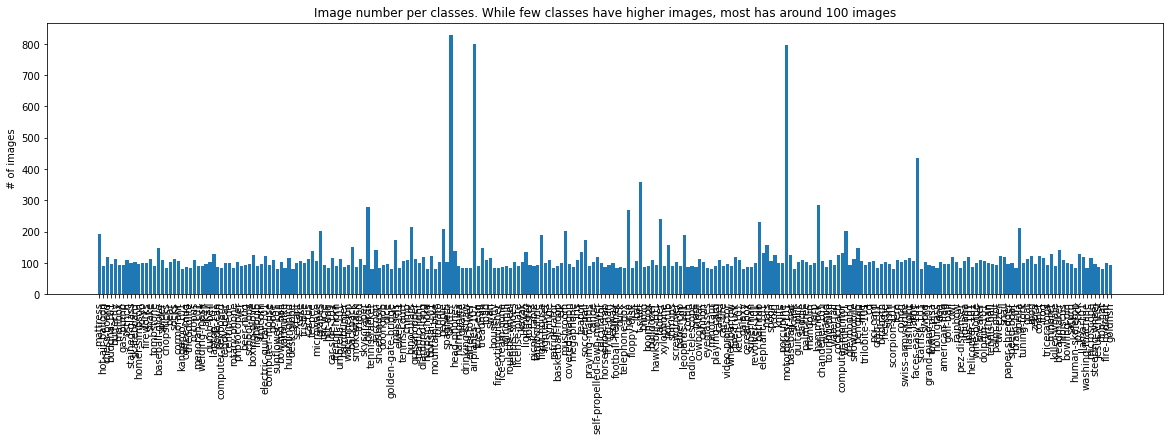

In [9]:
#visualize frequency per class categories
classes=hm.keys()
y_pos=np.arange(len(classes))
plt.figure(figsize=(20,5))
plt.bar(y_pos,class_freqs,align='center', alpha=1)
plt.xticks(y_pos,classes,rotation=90)
plt.ylabel('# of images')
plt.title('Image number per classes. While few classes have higher images, most has around 100 images')
plt.show()




In [10]:
#convert hm to X,y data mapping
#where each row of X is an image, y is it's class in int
import random
def make_Xy_Dense(hm,subset_classes):
    classes=list(hm.keys())
    random.shuffle(classes)
    classes=classes[0:subset_classes]
    X=[]
    y=[]
    for key in classes:
        images=hm[key]
        flatten_images=[]
        for i in images:
            flatten_images.append(i.flatten())
        X.extend(flatten_images)
        y.extend([key]*len(flatten_images))
    X=np.matrix(X)
    y=pd.get_dummies(y)
    
    return X,y        

In [11]:
X,y=make_Xy_Dense(hm,subset_classes=working_classes)
#make a test train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.20)

In [12]:
print(y_train.shape)
X_train.shape

(781, 10)


(781, 49152)

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras.backend as K
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [14]:

def DenseNetwork(X_train,y_train,input_dim,output_classes,
                 hidden_layer=2,units=[2048,2048], kernel_initializer='RandomNormal', 
                 hidden_layer_activation='relu',output_layer_activation='softmax', 
                 loss='categorical_crossentropy',metrics=['accuracy'],learning_rate=.1,
                 dropout=.5,batch_size=64,epochs=10,validation_split=.2):
    
    model= Sequential()
    
    for i in range(0,hidden_layer):
        model.add(Dense(units=units[0],kernel_initializer=kernel_initializer,input_dim=input_dim))
        model.add(BatchNormalization())
        model.add(Activation(hidden_layer_activation))
        model.add(Dropout(dropout))


    model.add(Dense(output_classes,kernel_initializer=kernel_initializer,activation=output_layer_activation))
    model.compile(Adam(lr=learning_rate),loss=loss,metrics=metrics)

    fit=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=validation_split)
    
    return fit


In [15]:
dense_fit=DenseNetwork(X_train,y_train,img_size*img_size*3,working_classes)

Train on 624 samples, validate on 157 samples
Epoch 1/10
624/624 [==============================] - 18s 29ms/step - loss: 28.7159 - accuracy: 0.1298 - val_loss: 1690.4895 - val_accuracy: 0.1019
Epoch 2/10
624/624 [==============================] - 12s 19ms/step - loss: 6.9503 - accuracy: 0.2212 - val_loss: 660.3641 - val_accuracy: 0.0955
Epoch 3/10
624/624 [==============================] - 12s 18ms/step - loss: 3.3849 - accuracy: 0.1763 - val_loss: 209.1091 - val_accuracy: 0.0955
Epoch 4/10
624/624 [==============================] - 13s 20ms/step - loss: 2.6848 - accuracy: 0.1763 - val_loss: 89.1121 - val_accuracy: 0.0764
Epoch 5/10
624/624 [==============================] - 12s 20ms/step - loss: 2.3216 - accuracy: 0.2420 - val_loss: 40.2081 - val_accuracy: 0.0892
Epoch 6/10
624/624 [==============================] - 12s 20ms/step - loss: 2.4619 - accuracy: 0.2083 - val_loss: 22.3624 - val_accuracy: 0.0828
Epoch 7/10
624/624 [==============================] - 13s 21ms/step - loss: 2.3